## Understanding Loop Dataset
This notebook tries provides details on the structure of the Loop dataset and makes suggestions how to process the data.

## Loop

### The study
**Title**: An Observational Study of Individuals with Type 1 Diabetes Using the Loop System for Automated Insulin Delivery: The Loop Observational Study (LOS)

**Description**: Passive data collection to collect data on the efficacy, safety, usability, and quality of life/ psychosocial effects of the Loop System
    
**Devices**: insulin pump and a Dexcom or Medtronic CGM

**Study Population**: People of any age with Type 1 Diabetes

### Data
The study data folder is named **Loop study public dataset 2023-01-31**

From the DataGlossary.rtf file, the following relevant files were identified which are stored in the **Data Tables** subfolder.

| File Name                     | Description                               | Note                                                                                           |
|-------------------------------|-------------------------------------------|-----------------------------------------------------------------------------------------------|
| **LOOPDeviceBasal<i>.txt**    | i=1-3, basal data exported from Tidepool | 3 files: 2.9GB, 2.9GB, and 1.35GB                                                             |
| **LOOPDeviceCGM<i>.txt**      | i=1-6, CGM data exported from Tidepool   | 6 files: 2.14GB, 2.24GB, 2.3GB, 2.31GB, 2.33GB, and 1.53GB.  Contains more patient IDs than Basal and Bolus files |
| **LOOPDeviceBolus.txt**       | Bolus data exported from Tidepool        | 1 file: 349MB                                                                                 |
| **PtRoster.txt**              | Patient Roster                           | Contains fixed UTC offsets which we need                                                     |

### Relevant Columns:
The following lists all relevant columns. Other columns were considered irrelevant. Some are still mentioned if they serve the discussion but crossed through.

#### LOOPDeviceCGM1-6
| Field_Name | Description | Note |
|----|----|-|
| **UTCDtTm** | Device date and time adjusted with timezone offset| These are UTC, the description is misleading! *1 |
| **RecordType**| Type of data (CGM, Calibration, etc)| Needed to drop calibrations|
| **CGMVal**| Glucose reading from the CGM (in mmol/L from Tidepool)| Convert to convert to mg/dl|
| ~~DeviceDtTm~~| Local device date and time; note not present in most rows because unavailable in Tidepool data source | *1 |
| ~~TmZnOffset~~| Timezone offset | *1 | 
| ~~Units~~ | Glucose reading units | all CGMs are in mmol/| 


#### LOOPDeviceBasal1-3

| Field Name | Glossary Description| Notes |
|-|-|-|
|**PtID**| Patient ID| Was not mentioned in glossary|
| **UTCDtTm**| Date and time with timezone offset| *1|
| **Rate** | Number of units per hour| **This is likely the only relevant value here**|
| ~~DeviceDtTm~~ | ~~Local device date and time; note not present in most rows because unavailable in Tidepool data source~~ |*1|
| ~~TmZnOffset~~ | ~~Timezone offset~~ | *1 | 
| BasalType| Basal delivery type | Unclear|
| Duration | Actual number of milliseconds basal will be in effect | Unclear |
| ExpectedDuration | Expected number of milliseconds basal will be in effect | Unclear|
| Percnt | Percentage of suppressed basal that should be delivered | Unclear|
| SuprBasalType| Suppressed basal delivery type (suppressed basal = basal event not being delivered because this one is active) | Unclear, Ambiguous description. JAEB did not use these values (see Q&A with JAEB below) |
| SuprDuration | Suppressed duration |Unclear|
| SuprRate | Suppressed rate | Unclear|

Example (first row):  
| PtID   | UTCDtTm| **BasalType** | Duration | ExpectedDuration | Percnt | Rate  | **SuprBasalType** | SuprDuration | SuprRate | TmZnOffset | 
|---|---|---|---|---|---|---|---|---|---|---|
| 1082 | 2018-05-29 10:02:56| **temp**| 244000   ||| 1.475 | **scheduled**|| 1.600|| 


#### LOOPDeviceBolus
| Field_Name| Description | Note |
|-|-|-|
| **UTCDtTm**| Device date and time (with timezone offset) |*1|
| **BolusType**| Subtype of data (ex: "Normal" and "Square" are subtypes of "Bolus" type)||
| **Normal** | Number of units of normal bolus |Likely the only relevant value.|
| ~~DeviceDtTm~~ | Local device date and time; note not present in most rows because unavailable in Tidepool data source |*1|
| ~~TmZnOffset~~ | Timezone offset |*1|
| ExpectedNormal | Expected number of units of normal bolus|Unclear|
| Extended | Number of units for extended delivery | We found that there are 0.4% extended boluses, probably triggered from the pump directly since Loop does not support these.|
| ExpectedExtended | Expected number of units for extended delivery|
| Duration | Time span over which the bolus was delivered (milliseconds for Tidepool data, minutes for Diasend data) | Our analysis shows that Duration refers to the Extended part of a Bolus. However, unclear how to find out wether in ms or minutes. JAEB couldn't answer.|
| ExpectedDuration | Expected time span over which the bolus should have been delivered (milliseconds for Tidepool data, minutes for Diasend data) |

We asked JAEB:

**Suppressed Deliveries:** What are suppressed deliveries in the context of basal data?    
> Answer: **We do not know** what the suppressed deliveries represent in this context, and we did not use this information for our analyses.  We calculated TDI using the Rate and Duration variables.  We suggest reaching out to Tidepool for information on suppressed deliveries.

**Patient IDs Discrepancy:** Why are there more patient IDs in the CGM files than in the Basal and Bolus files?  
> If available, CGM data from the participant’s personal CGM was collected for the 3 months prior to enrollment. A number of participants provided the retrospective personal CGM data but did not use Loop/provide us with their Loop data.

**Time Zones:** The UTCDtTm field does not include timezone information and TmZnOffset is only available when DeviceDtTm exists, which is rare. Local time might need to be extrapolated using backward / forward filling or using PtTimezoneOffset of the patient roster, which may not be reliable over long periods. How can local times be obtained for all patients, given the limited availability of DeviceDtTm and the potential inaccuracy of PtTimezoneOffset? 
>When we did the analysis, we used participant zip codes to estimate a local time. However, the zip code is not available in the public dataset. Instead, the variable PTTimezoneOffset in the PtRoster dataset can be applied to all UTC times to obtain a local time. During daylight savings, the offset should be reduced by 1.  This won’t be a perfect measure of the local time but should be a close approximation.

**Dexcom Times:** Are Dexcom DexInternalDtTm times in local time or UTC?  
> We did not use this variable because it is missing for the majority of cases.  We believe that it was only available in downloads from personal CGMs but not available in the data uploaded by Tidepool.  It may be the local time but may need to reach out to Dexcom to confirm this.

**Data Source Identification:** How can we determine if the data is uploaded from Tidepool or Diasend, especially since this affects the interpretation of extended boluses?  
> In most cases (perhaps all), Tidepool uploads are indicated by the OriginName field being equal to ‘.com.apple.HealthKit’.  However, we suggest reaching out to Tidepool as there might be scenarios where Diasend was involved in the data chain.

 - [1]:DeviceDtTm and TmZnOffset are only available for a fraction of patients. Therefore, we rely on UTCDtTm and patient roster PtTimezoneOffset to obtain local time. 
 - [2]: Loop has no extended boluses, check what this is

### Todos:  
Boluses:  
 - Need to check if the Normal portion is the actual delivered by comparing the values (<= in all cases would prove this to be true).
 - Check if there are extended boluses
 - Can we determine the delivery duration (ms or minutes) based on the data source?
Basals:
 - Need to double check if the Suppressed values are already factored in and if standard basal rates are reported as well.
 - Check potential values for columns like basal type (value-counts)


## Import

In [1]:
import os, sys
from datetime import datetime, timedelta, timezone
import time
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(),'..'))
from src import cdf
from src import postprocessing, drawing
#from dask.distributed import Client
#client = None
#if not client:
#    client = Client()
#client

#define path variables
study_name = 'Loop study public dataset 2023-01-31'
raw_path = os.path.join(os.getcwd(), '..', 'data', 'raw')
out_path = os.path.join(os.getcwd(), '..', 'data', 'out')
loop_path = os.path.join(raw_path, study_name)
df_patient= pd.read_csv(os.path.join(loop_path, 'Data Tables', 'PtRoster.txt'), sep='|')
loop_paquet_path = os.path.join(raw_path, 'paquet', study_name) 

## Datetime Analysis (using CGM subset)
We start by working with CGM data to understand how to obtain local datetimes. 

As we can see below, 
- **Datetimes:** DeviceDtTm and TmznOffset are mostly NaN, as discussed with JAEB, these are the only cases where we have true (int the sense of device reported) information about local datetime and the actual time zone offset.
 - **Memory usage:** 1GB for a single CGM file is too much. The patient data is spread accross various files which requires out of memory approaches.

In [2]:
#inspect LOOPDeviceCGM1.txt, one of 6 CGM files.
df_cgm = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceCGM1.txt'), sep='|',
                     usecols=['PtID', 'DeviceDtTm', 'TmZnOffset', 'UTCDtTm', 'RecordType', 'CGMVal', 'Units'])

memory_usage = df_cgm.memory_usage().sum() / 1024**2
print(f"Memory usage: {memory_usage:.2f} MB (before optimization)")

#optimize data by storage size
df_cgm['UTCDtTm'] = pd.to_datetime(df_cgm.UTCDtTm, format='%Y-%m-%d %H:%M:%S')
df_cgm['DeviceDtTm'] = pd.to_datetime(df_cgm.DeviceDtTm, format='%Y-%m-%d %H:%M:%S')
df_cgm['TmZnOffset'] = pd.to_timedelta(df_cgm.TmZnOffset, unit='minute')

df_cgm = df_cgm.loc[df_cgm.RecordType == 'CGM'].drop(columns=['RecordType'])
df_cgm = df_cgm.drop(columns=['Units'])

memory_usage = df_cgm.memory_usage().sum() / 1024**2
print(f"Memory usage: {memory_usage:.2f} MB (after optimization)")

def count_na(series):
    return series.isna().sum()
display(df_cgm.agg(['count', count_na, 'nunique']).T)

/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_26245/3485888083.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cgm = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceCGM1.txt'), sep='|',


Memory usage: 1010.96 MB (before optimization)
Memory usage: 865.75 MB (after optimization)


,count,count_na,nunique
PtID,18912614,0,589
DeviceDtTm,6128194,12784420,5629581
UTCDtTm,18912614,0,14581839
CGMVal,18912614,0,315660
TmZnOffset,5917165,12995449,15


### Understanding Datetimes
Are these local times? This is what the glossary says:
 - `DeviceDtTm`: Local device date and time; note not present in most rows because unavailable in Tidepool data source
 - `UTCDtTm`: Device date and time adjusted with timezone offset
 -`DexInternalDtTm` Dexcom Internal date and time
 -`TmZnOffset`: Timezone offset

While we assume ```DeviceDtTm = UTCDtTm + TmZnOffset``` the glossary is a little ambiguous so we plot patient data and the distribution.


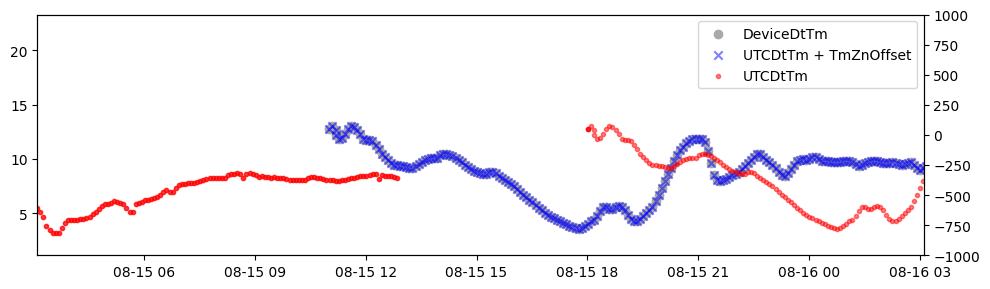

In [3]:
#ploting a single patient's CGM data
pt_grps = df_cgm.groupby('PtID', observed=False)
subframe = pt_grps.get_group(1173).copy()
subframe['AdjustedDtTm'] = subframe.UTCDtTm + pd.to_timedelta(subframe.TmZnOffset, unit='minute')

temp = subframe.dropna(subset=['DeviceDtTm']).sort_values(['DeviceDtTm'])

fig, ax = plt.subplots(figsize=(10, 3)); twinx = ax.twinx()
offset=4.5

ax.scatter(temp.DeviceDtTm, temp.CGMVal, label='DeviceDtTm', marker='o',alpha=1, color='darkgray')
ax.scatter(temp.AdjustedDtTm, temp.CGMVal, label='UTCDtTm + TmZnOffset', marker='x', alpha=0.5,color='blue')

temp = subframe.dropna(subset=['UTCDtTm']).sort_values(['UTCDtTm'])
ax.scatter(temp.UTCDtTm, temp.CGMVal, label='UTCDtTm', marker='.',alpha=0.5,color='red')
twinx.plot(temp.UTCDtTm, temp.TmZnOffset, label='TmZnOffset')

ax.set_xlim(temp.UTCDtTm.min()+timedelta(days=offset), temp.UTCDtTm.min()+timedelta(days=offset+1))
twinx.set_ylim(-1000, 1000); ax.legend(); plt.tight_layout()
plt.show()
del subframe, temp

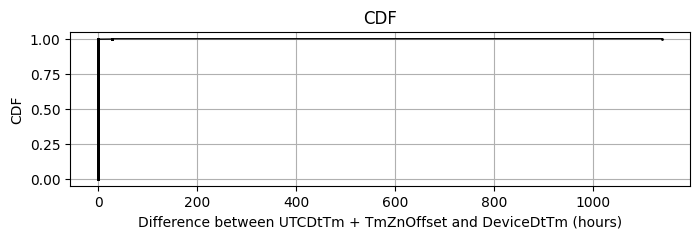

In [4]:
# plot the difference between UTCDtTm + TmZnOffset and DeviceDtTm
temp = df_cgm.sample(10000).dropna(subset=['UTCDtTm','DeviceDtTm','TmZnOffset'],how='any').copy()
temp['UTCDtTm'] = pd.to_datetime(temp.UTCDtTm)
temp['DeviceDtTm'] = pd.to_datetime(temp.DeviceDtTm)

temp.loc[:,'Diff'] = (temp.DeviceDtTm - (temp.UTCDtTm + pd.to_timedelta(temp.TmZnOffset, unit='minute'))).dt.total_seconds()/3600

plt.figure(figsize=(8, 2)); ax = plt.gca()
cdf.plot_cdf(temp.Diff.abs(), xlabel='Difference between UTCDtTm + TmZnOffset and DeviceDtTm (hours)', ax=ax)

(Note: We see that some differences are not equal to zero. In these cases, the time shift is a fraction of hours. We don't know why that is.)

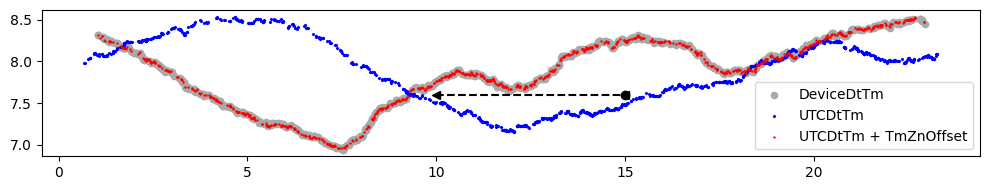

In [5]:
#plot daytime average CGM values

#reduce data to those with values in both timestamp columns
temp = df_cgm.sample(100000).dropna(subset=['UTCDtTm','DeviceDtTm','TmZnOffset'],how='any').copy()
temp['DeviceDtTm'] = pd.to_datetime(temp.DeviceDtTm)
temp['UTCDtTm'] = pd.to_datetime(temp.UTCDtTm)
temp['datetime'] = pd.to_datetime(temp.UTCDtTm) + pd.to_timedelta(temp.TmZnOffset, unit='minute')

#calculate the hour of day for each timestamp
temp['DeviceDtTm_hod'] = temp.DeviceDtTm.dt.hour+temp.DeviceDtTm.dt.minute/60+temp.DeviceDtTm.dt.second/3600
temp['UTCDtTm_hod'] = temp.UTCDtTm.dt.hour+temp.UTCDtTm.dt.minute/60+temp.UTCDtTm.dt.second/3600
temp['datetime_hod'] = temp.datetime.dt.hour+temp.datetime.dt.minute/60+temp.datetime.dt.second/3600

#calcualte centered moving average
window = 2000
ma_DeviceDtTm  = temp[['CGMVal','DeviceDtTm_hod']].sort_values('DeviceDtTm_hod').rolling(window=window, min_periods=window, on='DeviceDtTm_hod', center=True).mean().sample(1000)
ma_UTCDtTm  = temp[['CGMVal','UTCDtTm_hod']].sort_values('UTCDtTm_hod').rolling(window=window, min_periods=window, on='UTCDtTm_hod', center=True).mean().sample(1000)
ma_datetime  = temp[['CGMVal','datetime_hod']].sort_values('datetime_hod').rolling(window=window, min_periods=window, on='datetime_hod', center=True).mean().sample(1000)

#draw
plt.figure(figsize=(10,2)); 
plt.scatter(ma_DeviceDtTm.DeviceDtTm_hod, ma_DeviceDtTm.CGMVal, label='DeviceDtTm', color='darkgray', marker='o',s=20)
plt.scatter(ma_UTCDtTm.UTCDtTm_hod, ma_UTCDtTm.CGMVal, label='UTCDtTm', color='blue', marker='x',s=2)
plt.scatter(ma_datetime.datetime_hod, ma_datetime.CGMVal, label='UTCDtTm + TmZnOffset', color='red', marker='.',s=2)

plt.plot([10,15],[7.6,7.6], color='black', linestyle='--', marker='<')
plt.plot([15],[7.6], color='black', marker='o')
plt.legend(); plt.tight_layout()


From this we can clearly see that 

1. DeviceDtTm and the offset compensated utc aligns with expected diurnal, postprandial patterns (pronounced peak in the morning, noon and evening). 
2. Using UTC alone (blue), the peaks are less pronounced and roughly offset by 5 hours (black arrow) (At UTC 15:00 we see the morning peak, which really is at around 10:00 (-5h). This is in line with the fact that the majority of time zone offsets is around -300 minutes (-5hours). Note that just compensating UTC by 5 hours does not give the same pronounced peaks, since there are users with other offsets, the peaks are washed out.

We can conclude that ```DeviceDtTm = UTCDtTm + TmZnOffset``` with DeviceDtTm being the local time. And that the glossary description *"UTCDtTm : Device date and time (with timezone offset)"* is misleading.


However, we can **not rely** on DeviceDtTm and TmZnOffset because it only exists for a fraction of the data. Therefore we need to rely on UTCDtTm and either  
 * extrapolate TmZnOffset
 * use the patient roster time zone offsets

### Which Offset to use?

One option would be to extrapolate the `TmZnOffset` (bfill/ffill)? To check if this is a viable option we check how many patients have TmZnOffset data.  We do this by checking the fraction of patients with at least one TmZnOffset value. As we can see below, this is clearly not enough. 

37.18% of patients have at least one timezone offset


Text(0.5, 1.0, 'Availability of timezone offsets for patients with at least one')

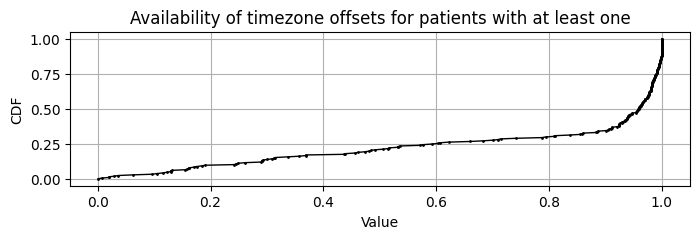

In [6]:
#check fraction of patients with at least one timezone offset
frac = (df_cgm.groupby('PtID').TmZnOffset.count()>1).sum()/df_cgm.PtID.nunique()
print(f'{frac:.2%} of patients have at least one timezone offset')

#check fraction of non NaN offsets for patients with at least one
pts_with_data = df_cgm.dropna(subset=['TmZnOffset'] ).PtID.unique()
temp = df_cgm.loc[df_cgm.PtID.isin(pts_with_data)]
temp = temp.groupby('PtID').TmZnOffset.agg(lambda x: x.notna().mean())

plt.figure(figsize=(8,2)); ax = plt.gca()
cdf.plot_cdf(temp,ax=ax)
plt.title('Availability of timezone offsets for patients with at least one')

Instead, we could use the `PtTimezoneOffset` (utc offset in hours) from the patient roster. To understand if using this *static* value is acceptable, we want to understand how often the actual timezone changes.

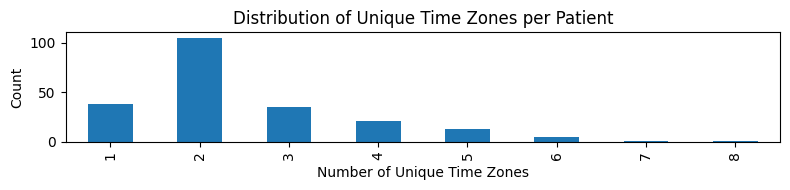

65.3% of patients have 2 unique time zones or less


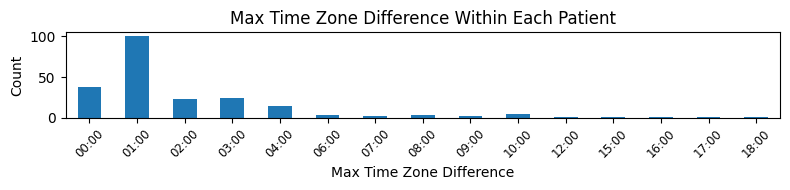

63.0% of patients have shifts of 1 hours or less


In [7]:
#report time zone offsets and changes within patients
def timedetla_formatter(td):
    return f"{td.seconds // 3600 + td.days * 24:02d}:{(td.seconds % 3600) // 60:02d}"

#number of time zones per patient
number_time_zones = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.nunique()
number_time_zones = number_time_zones.value_counts().sort_index()

plt.figure(figsize=(8, 2)); ax=plt.gca()
number_time_zones.plot(kind='bar', ax=ax)
plt.xlabel('Number of Unique Time Zones')
plt.ylabel('Count')
plt.title('Distribution of Unique Time Zones per Patient')
plt.tight_layout(); plt.show()

print(f'{100*number_time_zones.loc[0:2].sum()/number_time_zones.sum():2.1f}% of patients have 2 unique time zones or less')


#max difference within a patient
tzdiff_within = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.agg(lambda x: x.max()-x.min())
tzdiff_within = tzdiff_within.value_counts().sort_index()

plt.figure(figsize=(8, 2)); ax=plt.gca()
tzdiff_within.plot(kind='bar', ax=ax)
tick_labels = [timedetla_formatter(x) for x in tzdiff_within.index]
ax.set_xticklabels(tick_labels, rotation=45,fontsize='small')
plt.xlabel('Max Time Zone Difference');plt.ylabel('Count')
plt.title('Max Time Zone Difference Within Each Patient')
plt.tight_layout();plt.show()

print(f'{100*tzdiff_within[tzdiff_within.index<=timedelta(hours=1)].sum()/tzdiff_within.sum():2.1f}% of patients have shifts of 1 hours or less')


# #Which time zones exist?
# all_time_zones = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.unique().explode()
# plt.figure(figsize=(8, 2)); ax=plt.gca()
# all_time_zones= all_time_zones.value_counts().sort_index()
# all_time_zones.plot(kind='bar', logy=True, ax=ax)
# tick_labels = [timedetla_formatter(x) for x in all_time_zones.index]
# ax.set_xticklabels(tick_labels, rotation=45,fontsize='small')

# plt.xticks(rotation=45, fontsize='small')
# plt.xlabel('Time Zone Offset'); plt.ylabel('Count'); plt.title('Distribution of Time Zone Offsets')
# plt.tight_layout();plt.show()

#### Estimate static time zone error

We see that 
 - Majority of most patients experience more than 1 time zones.
 - The majority is a change of 1 hour. Likely the result of daylight saving times. 
- But, a significant fraction experiences changes of 2,3 or 4 hours or more. This is nothing, that we could account for. While we can remove patients with more frequent changes in `TmZnOffset`, almost 2/3 of the patients have no data in that column. 

However, these time zone changes are likely infrequent as most patients will travel for short periods only. Let's estimate the expected error. To estimate the error, we compare the static offsets from the patient roster with the device reported offsets for those user that have it.

In [8]:
## obtaining local times from utc and patient roster offsets

# joining tables
df_patient['PtTimezoneOffset'] = pd.to_timedelta(df_patient.PtTimezoneOffset, unit='hour')
df_cgm = df_cgm.join(df_patient[['PtID','PtTimezoneOffset']].set_index('PtID'), on='PtID', how='left')

# converting to localized datetime
#method 1: getting localized datetimes (much slower)
#df_cgm['datetime'] = pd.to_datetime(df_cgm.UTCDtTm, utc=True)
#df_cgm['datetime'] = df_cgm.apply(lambda x: x.datetime.tz_convert(timezone(offset=x.PtTimezoneOffset)), axis=1)

#method 2: or as naive datetime (simply adding the offset)
df_cgm['datetime']= df_cgm.UTCDtTm+ df_cgm.TmZnOffset
#display(df_cgm.dropna(subset=['TmZnOffset']).sample(3))

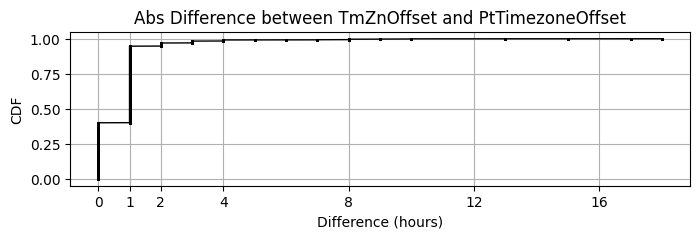

In [9]:
#plotting the difference between CGM TmZnOffset and PtTimezoneOffset

diff = df_cgm.TmZnOffset - df_cgm.PtTimezoneOffset
diff = abs(diff.dropna().dt.total_seconds()/3600)

plt.figure(figsize=(8, 2)); ax = plt.gca()
cdf.plot_cdf(diff,ax=ax); plt.xlabel('Difference (hours)');
plt.title('Abs Difference between TmZnOffset and PtTimezoneOffset');
plt.xticks([0,1,2,4,8,12,16]); #plt.tight_layout(); plt.show()

#get cumulative stats
# print(f'{(diff>=2).mean():.1%} of time zone differences are >2 hours')
# error_counts = diff.value_counts(bins=[-1, 0, 1, 2, 3, 4, float('inf')], sort=False)
# error_percentages = (error_counts / error_counts.sum()) * 100
# error_percentages.name = 'Percentage'
# cumsum_report = error_percentages.cumsum()
# cumsum_report.name = 'Cumulative Percentage'
# cumsum_report.index = [f'<={x.right:.0f}' for x in error_counts.index]
# display(cumsum_report)

This doesn't look too bad.  When using the static patient roster utc offset, the local time error will be <2 hours for >96% of the cases.

### Conclusion
Local datetimes can be obtained with a small estimated error (<2 hours for >96% of the cases) by using the patient roster static time zone utc offsets PtTimezoneOffset and UTCDtTm utc timestamps. 

```local_time = UTCDtTm + PtTimezoneOffset```

## CGM

### Loading using dask


Processing patient data requires us to load all files into memory at once because the patient data is spread accross all CGM files. While we could use dask on the csvs directly, this would create a lot of overhead (shuffling to perform grouped conversions). 
Instead, we convert the data into a paquet format, splitting it by patient id. This allows us to process patients iteratively and in parallel.

In [10]:
## export CGM to parquet if not already done
re_export = False
cgm_parquet_path = os.path.join(loop_paquet_path, 'cgm')

if not os.path.exists(cgm_parquet_path):
    temp = dd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceCGM*.txt'), sep='|', 
                parse_dates=['UTCDtTm'], date_format='%Y-%m-%d %H:%M:%S', 
                usecols=['PtID', 'UTCDtTm', 'RecordType', 'CGMVal'])
    temp.to_parquet(os.path.join(loop_paquet_path,'cgm'), partition_on='PtID')
else:
    print(f'Parquet files already exist in {loop_paquet_path}')

Parquet files already exist in /Users/jan/git/nudgebg/egvinsulin/notebooks/../data/raw/paquet/Loop study public dataset 2023-01-31


In [11]:
#load parquet and a subset
ddf_cgm = dd.read_parquet(os.path.join(loop_paquet_path,'cgm'), aggregate_files='PtID')
df_cgm_sample = ddf_cgm.sample(frac=0.1).compute().reset_index()

In [12]:
#display the COLUMNS
print('COLUMNS:')
print(df_cgm_sample.columns)

COLUMNS:
Index(['index', 'UTCDtTm', 'RecordType', 'CGMVal', 'PtID'], dtype='object')


### Check for Magic CGM Values

Let's check on CGM distribution. As we can see below, 0 and 400 CGM values are capped (as expected) but no 0 values exist.

Number of values around 0: 0


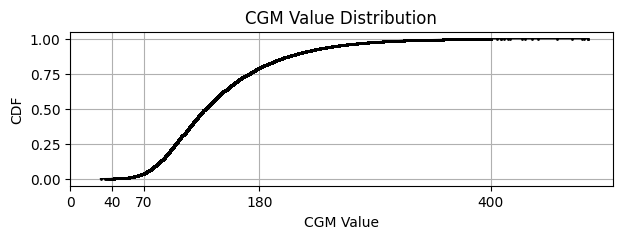

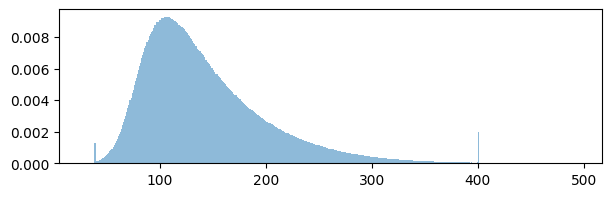

In [13]:
#Visualize CGM Distribution
#R = ddf_cgm.map_partitions(lambda x: x.CGMVal.sample(n=min(1000,len(x)))).compute()
print(f"Number of values around 0: {((df_cgm_sample.CGMVal<1) & (df_cgm_sample.CGMVal>-1)).sum()}")
plt.figure(figsize=(7, 2)); ax = plt.gca()
cdf.plot_cdf(df_cgm_sample.CGMVal*18, xlabel='CGM Value', ylabel='CDF', title='CGM Value Distribution',ax=ax)
plt.xticks([0,40,70,180,400]);

plt.figure(figsize=(7, 2)); ax = plt.gca()
vc = (df_cgm_sample.CGMVal*18).round().value_counts(normalize=True).sort_index()
plt.bar(vc.index,vc.values, width=1, alpha=0.5);
del vc

### Duplicates

In [14]:
#print duplicates
def report_duplicates(ddf, subset, sort_by):
    # Combine duplicated counts into a single computation
    def count_duplicates(df, subset=None):
        return df.duplicated(subset=subset, keep=False)

    # Map partitions once and compute all duplicates
    duplicate_flags = ddf.map_partitions(lambda x: {
        "all": count_duplicates(x),
        "subset": count_duplicates(x, subset=subset)
    }).compute()

    # Aggregate results
    total_duplicates_all = sum(df["all"].sum() for df in duplicate_flags)
    total_duplicates_subset = sum(df["subset"].sum() for df in duplicate_flags)

    # Print results
    display(f'{total_duplicates_all} duplicates ({100 * total_duplicates_all / len(ddf):.2f}%)')
    display(f'{total_duplicates_subset} duplicates ({100 * total_duplicates_subset / len(ddf):.2f}%) {subset}')

    # Combine all partitions for display
    # Extract the first 1000 rows from each partition
    first_1000_per_partition = ddf.map_partitions(lambda df: df.head(1000)).compute()
    # Identify duplicates in the subset
    duplicates = first_1000_per_partition[first_1000_per_partition.duplicated(keep=False)]
    display(duplicates.head(4))
    duplicates = first_1000_per_partition[first_1000_per_partition.duplicated(keep=False,subset=subset)]
    display(duplicates.head(4))


In [15]:
report_duplicates(ddf_cgm, ['UTCDtTm'], ['UTCDtTm'])

'38562037 duplicates (34.70%)'

"42680198 duplicates (38.41%) ['UTCDtTm']"

,UTCDtTm,RecordType,CGMVal,PtID
139293,2018-10-15 03:58:06,CGM,7.77105,3
139592,2018-10-15 03:58:06,CGM,7.77105,3
249929,2018-12-27 03:35:00,CGM,9.26975,6
249930,2018-12-27 03:35:00,CGM,9.26975,6


,UTCDtTm,RecordType,CGMVal,PtID
139022,2018-10-08 09:55:26,CGM,8.99221,3
139023,2018-10-08 09:50:26,CGM,9.15873,3
139024,2018-10-08 09:45:26,CGM,9.21424,3
139026,2018-10-08 09:35:26,CGM,8.54815,3


#### Check for correlation

In [16]:
duplicated_cgms = ddf_cgm.map_partitions(lambda x: x[x.duplicated(subset=['UTCDtTm'], keep=False)].sort_values('UTCDtTm').head(100)).compute()

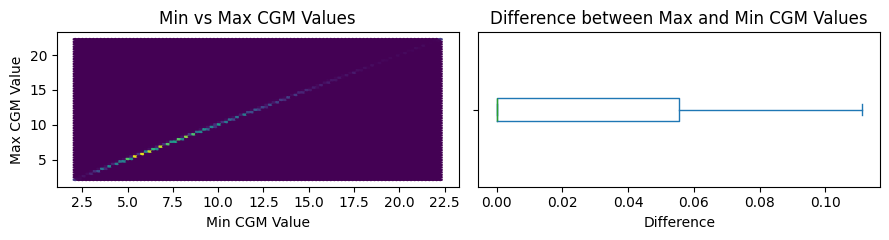

In [17]:
duplicated_cgms['PtID'] = duplicated_cgms.PtID.astype('str')
duplicated_cgms = duplicated_cgms.sort_values(['PtID','UTCDtTm'])
results = duplicated_cgms.groupby(['PtID','UTCDtTm']).CGMVal.agg(['min','max'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2.5))

# Scatter plot
ax1.hexbin(results['min'], results['max'], gridsize=100, cmap='viridis')
ax1.set_xlabel('Min CGM Value')
ax1.set_ylabel('Max CGM Value')
ax1.set_title('Min vs Max CGM Values')

# Box plot
d = (results['max'] - results['min'])
d.plot.box(vert=False, ax=ax2, showfliers=False)
ax2.set_title('Difference between Max and Min CGM Values')
ax2.set_xlabel('Difference')

plt.tight_layout()
plt.show()

### Missing Data

In [18]:
#print NaNs and Record Type fractions
print('NAN VALUES:')
temp = df_cgm_sample.isna().sum()
print(f"overall nan values = {temp.sum()}")
display(100*temp/len(df_cgm_sample))

print('Record Type:')
display(df_cgm_sample.value_counts(subset=['RecordType'])*100/len(df_cgm_sample))
del temp

NAN VALUES:
overall nan values = 0


index         0.0
UTCDtTm       0.0
RecordType    0.0
CGMVal        0.0
PtID          0.0
dtype: float64

Record Type:


RecordType 
CGM            99.94675
Calibration     0.05325
Name: count, dtype: float64

### CGM Conclusion
- Many duplicates that need to be dropped
 - CGM Data must be converted from mmols to mg/dl
 - There are no NaN values
 - Calibrations need to be dropped
 


### Extract CGM based on learnings

In [19]:
# Extract CGM data based on what we learned using Dask
#read CGM files, partitioned by PtID
ddf_cgm_extract = ddf_cgm.rename(columns={'PtID': 'patient_id', 'UTCDtTm': 'UTCDtTm', 'RecordType': 'RecordType', 'CGMVal': 'cgm'})
ddf_cgm_extract = ddf_cgm_extract.set_index('patient_id')#,drop=False) # make sure divisions are set correctly, keep patient_id as column

#drop calibrations
ddf_cgm_extract = ddf_cgm_extract.loc[ddf_cgm_extract.RecordType == 'CGM']
ddf_cgm_extract.index = ddf_cgm_extract.index.astype('int') #a workaround to obmit error occuring when there were no rows left
ddf_cgm_extract = ddf_cgm_extract.drop(columns=['RecordType'])

#convert to mg/dL
ddf_cgm_extract['cgm'] = ddf_cgm_extract.cgm*18.018 

#convert utc to local datetime
#TODO: When i do not rename PTID here, then result = ddf.groupby(by='patient_id').apply(postprocessing.cgm_transform); result.loc[3].compute().head(10); 
# will fail with 'KeyError: 'patient_id' this is weird because ddf.index.name still yields patient_id
patient_roster = df_patient[['PtID','PtTimezoneOffset']].rename(columns={'PtID':'patient_id'}).set_index('patient_id')
ddf_cgm_extract = ddf_cgm_extract.join(patient_roster, how='left')
ddf_cgm_extract['datetime'] = ddf_cgm_extract.UTCDtTm + dd.to_timedelta(ddf_cgm_extract.PtTimezoneOffset, unit='hour')
ddf_cgm_extract = ddf_cgm_extract.drop(columns=['UTCDtTm', 'PtTimezoneOffset'])


In [20]:
# Resample subset of CGM data using dask

#Method 1: using groupby: this works but only if we previously renamed the PtID of the patient roster index to 'patient_id' before the join
meta={'datetime': 'datetime64[ns]', 'cgm': 'float64'}
result = ddf_cgm_extract.groupby(by='patient_id').apply(postprocessing.cgm_transform, meta=meta)
display(result.loc[3].compute().head(5))

del meta, result

#Method 2: using map_partitions: this works but we loose the patient index, workaround:
# def wrapper(df):
#     assert df.index.nunique() == 1
#     r= postprocessing.cgm_transform(df)
#     r.assign('patient_id', df.index[0])

# start_time = time.time()    
# loop_cgm_transformed = ddf_cgm.map_partitions(postprocessing.cgm_transform, meta=meta)
# transformed_partition = loop_cgm_transformed.get_partition(0).compute()
# display(transformed_partition.head(10))
# end_time = time.time()
# print(f"Execution time: {end_time - start_time} seconds")


[18:36:41] The index is not sorted. Sorting the index.
/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_26245/3315765040.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tdds = copy.groupby('date').apply(tdd).to_frame().rename(columns={0:'basal'})
/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_26245/3315765040.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tdds = copy.groupby

datetime         cgm
patient_id                                  
3          0 2018-06-15 19:00:00  396.516721
           1 2018-06-15 19:05:00  394.273480
           2 2018-06-15 19:10:00  387.947360
           3 2018-06-15 19:15:00         NaN
           4 2018-06-15 19:20:00  338.812274

## Boluses

In [21]:
#read bolus as pandas dataframe (it is small enough)
df_bolus = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceBolus.txt'), sep='|', 
                        parse_dates=['UTCDtTm'], date_format='%Y-%m-%d %H:%M:%S')
df_bolus = df_bolus.drop(columns=['RecID'])

/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_26245/3861500938.py:2: DtypeWarning: Columns (3,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bolus = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceBolus.txt'), sep='|',


In [22]:
def report_duplicates_pandas(df, subset, sort_by):    
    bDuplicated = df.duplicated(keep=False)
    print(f'{bDuplicated.sum()} duplicates ({100*bDuplicated.sum()/len(df):.2f}%)')
    print('Duplicated rows:')
    display(df[bDuplicated].dropna(axis=1).sort_values(sort_by).head(2))
    

    bDuplicated = df.duplicated(subset=subset, keep=False)
    print(f'{bDuplicated.sum()} duplicates ({100*bDuplicated.sum()/len(df):.2f}%) {subset}')
    print(f'Duplicated rows subset {subset}:')
    display(df[bDuplicated].dropna(axis=1).sort_values(sort_by).head(2))


In [23]:
## Report Columns, Nans, Duplicates, 

#print stats for bolus dataframe
print('COLUMNS:')
print(df_bolus.columns)

#display the value counts
print('VALUE FRACTIONS:')
display(df_bolus.value_counts(subset=['BolusType'])*100/len(df_bolus))

#display the nan values
print('NAN FRACTIONS')
display(100*df_bolus.isna().sum()/len(df_bolus))

print('DUPLICATES:')
report_duplicates_pandas(df_bolus, ['UTCDtTm', 'PtID'], ['UTCDtTm'])


COLUMNS:
Index(['PtID', 'ParentLOOPDeviceUploadsID', 'DeviceDtTm', 'UTCDtTm',
       'BolusType', 'Normal', 'ExpectedNormal', 'Extended', 'ExpectedExtended',
       'Duration', 'ExpectedDuration', 'TmZnOffset', 'OriginName',
       'OriginVers', 'OriginType', 'OriginDeviceFirmwrVer',
       'OriginDeviceHardwrVer', 'OriginDeviceManufact', 'OriginDeviceModel',
       'OriginOperatingSystVer', 'OriginProductType'],
      dtype='object')
VALUE FRACTIONS:


BolusType  
normal         99.615245
dual/square     0.326720
square          0.058035
Name: count, dtype: float64

NAN FRACTIONS


PtID                          0.000000
ParentLOOPDeviceUploadsID     0.000000
DeviceDtTm                   94.315252
UTCDtTm                       0.000000
BolusType                     0.000000
Normal                        0.058035
ExpectedNormal               99.498294
Extended                     99.615245
ExpectedExtended             99.933664
Duration                     99.615245
ExpectedDuration             99.933664
TmZnOffset                   94.315252
OriginName                    5.684748
OriginVers                    5.684858
OriginType                    5.684748
OriginDeviceFirmwrVer        10.654054
OriginDeviceHardwrVer        99.912875
OriginDeviceManufact          7.744095
OriginDeviceModel             7.744095
OriginOperatingSystVer        5.684748
OriginProductType             5.684748
dtype: float64

DUPLICATES:
501545 duplicates (18.42%)
Duplicated rows:


,PtID,ParentLOOPDeviceUploadsID,UTCDtTm,BolusType,Normal
1909539,993,1166915,2017-11-14 18:37:40,normal,0.03
1909538,993,1166915,2017-11-14 18:37:40,normal,0.03


566504 duplicates (20.81%) ['UTCDtTm', 'PtID']
Duplicated rows subset ['UTCDtTm', 'PtID']:


,PtID,ParentLOOPDeviceUploadsID,UTCDtTm,BolusType
1909538,993,1166915,2017-11-14 18:37:40,normal
1909539,993,1166915,2017-11-14 18:37:40,normal


### Duplicates
As we can see above, there are significant amount of duplicates and that most duplicated rows are completely identical (except for the record id). 
However, we also see slightly more duplicates when using ['UTCDtTm', 'PtID'] as subset. This means that there are rows that have equal  ['UTCDtTm', 'PtID'] but vary otherwise. Let's check when this happens:

In [26]:
df_bolus = df_bolus.drop_duplicates()
b_duplicated_subset = df_bolus.duplicated(subset=['UTCDtTm','PtID'], keep=False)
print(f'{b_duplicated_subset.sum()} duplicates ({100*b_duplicated_subset.sum()/len(df_bolus):.2f}%) UTCDtM, PtID')
#del b_duplicated_subset

72891 duplicates (2.97%) UTCDtM, PtID


In [28]:
df_bolus[b_duplicated_subset].sort_values(['PtID', 'UTCDtTm']).head(2).dropna(axis=1, how='all')

,PtID,ParentLOOPDeviceUploadsID,UTCDtTm,BolusType,Normal,OriginName,OriginVers,OriginType,OriginDeviceFirmwrVer,OriginDeviceManufact,OriginDeviceModel,OriginOperatingSystVer,OriginProductType
437671,3,1300475,2018-10-16 13:56:29,normal,0.3,com.apple.HealthKit,55,service,2.7.0,Insulet,Eros,12.2.0,"iPhone10,4"
1705687,3,1300475,2018-10-16 13:56:29,normal,0.3,com.apple.HealthKit,55,service,2.8.0,Insulet,Eros,12.2.0,"iPhone10,4"


Here we see differences in the firmware. But are there also duplicates with different bolus doses?

In [29]:
# Print some duplicated rows with different boluses
duplicated_rows = df_bolus[df_bolus.duplicated(subset=['PtID', 'UTCDtTm'], keep=False)]
different_normal = duplicated_rows.groupby(['PtID', 'UTCDtTm']).filter(lambda x: x['Normal'].nunique() > 1)
display(different_normal.sort_values(['PtID', 'UTCDtTm']).head(2).dropna(axis=1, how='all'))
del duplicated_rows

,PtID,ParentLOOPDeviceUploadsID,UTCDtTm,BolusType,Normal,OriginName,OriginVers,OriginType,OriginDeviceFirmwrVer,OriginDeviceManufact,OriginDeviceModel,OriginOperatingSystVer,OriginProductType
583713,4,1312477,2019-01-10 01:22:31,normal,15.0,com.apple.HealthKit,54,service,subg_rfspy 0.9,Medtronic,722,12.2.0,"iPhone11,6"
583714,4,1312477,2019-01-10 01:22:31,normal,9.2,com.apple.HealthKit,54,service,subg_rfspy 0.9,Medtronic,722,12.2.0,"iPhone11,6"


We see that there are instances where we have temporal duplicates with different values and it is unclear which one to trust.

#### Check for Correlation

count    156494.000000
mean          0.003133
std           0.129189
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          24.600000
dtype: float64

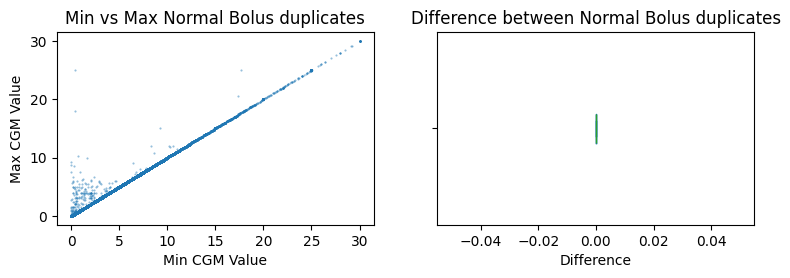

In [30]:
duplicated_boluses = df_bolus[df_bolus.duplicated(subset=['UTCDtTm'], keep=False)].sort_values('UTCDtTm')

results = duplicated_boluses.groupby(['PtID','UTCDtTm']).Normal.agg(['min','max'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2.5))

# Scatter plot
ax1.scatter(results['min'], results['max'],alpha=0.5,s=1,marker='.')
ax1.set_xlabel('Min CGM Value')
ax1.set_ylabel('Max CGM Value')
ax1.set_title('Min vs Max Normal Bolus duplicates')

# Box plot
d = (results['max'] - results['min'])
d.plot.box(vert=False, ax=ax2, showfliers=False)
ax2.set_title('Difference between Normal Bolus duplicates')
ax2.set_xlabel('Difference')

d.describe()

We see that sometimes boluses are drastically different. We don't know why that is and we wouldn't know which value to pick.

### Dual wave Boluses
We know there are some dual wave and extended boluses. Since loop does not support these natively, these were likey initiated from the pump or during open loop mode.

In [31]:
#print the fraction of extended boluses
print(f'{100*df_bolus.Extended.notna().mean():.2f}% of boluses are extended')
print(f'In {(df_bolus.Extended.notna() == df_bolus.Duration.notna()).mean():.1%} of all rows, it is either extended and duration are filled or neither')
display(df_bolus.loc[df_bolus.Extended.notna()].head(3).dropna(axis=1,how='all'))

0.43% of boluses are extended
In 100.0% of all rows, it is either extended and duration are filled or neither


,PtID,ParentLOOPDeviceUploadsID,DeviceDtTm,UTCDtTm,BolusType,Normal,Extended,Duration,TmZnOffset
31932,982,335722,2018-10-28 19:06:49,2018-10-29 00:06:49,dual/square,7.5,3.2,9900000.0,-300.0
31942,982,335722,2018-11-11 18:07:34,2018-11-11 23:07:34,dual/square,4.8,5.9,9000000.0,-300.0
32305,982,335723,2018-09-30 20:13:16,2018-10-01 00:13:16,dual/square,6.8,4.6,7200000.0,-240.0


From the glossary we know that the duration is either in ms or minutes.  Let's try to figure out if duration is milliseconds or minutes from the distributions.

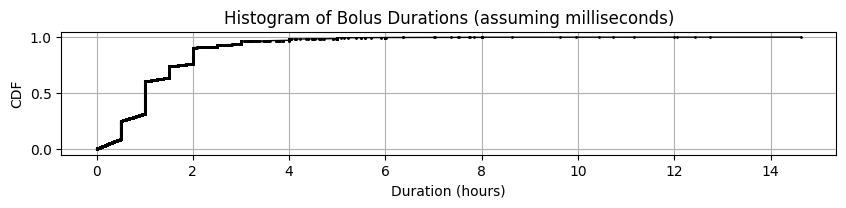

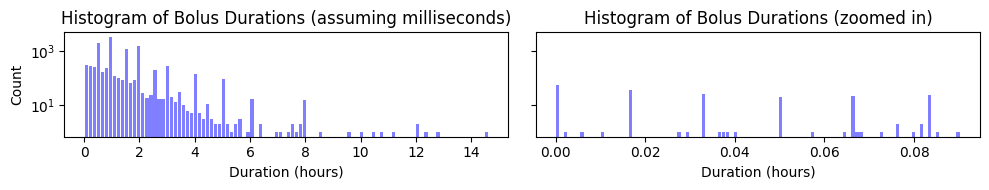

EXAMPLES of durations <0.01:


,PtID,ParentLOOPDeviceUploadsID,DeviceDtTm,UTCDtTm,BolusType,Normal,ExpectedNormal,Extended,ExpectedExtended,Duration,...,TmZnOffset,OriginName,OriginVers,OriginType,OriginDeviceFirmwrVer,OriginDeviceHardwrVer,OriginDeviceManufact,OriginDeviceModel,OriginOperatingSystVer,OriginProductType
1025711,270,959525,2019-07-23 07:35:00,2019-07-23 14:35:00,dual/square,0.5,NaN,0.42,0.5,0.0,...,-420.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1066762,270,959525,2019-07-31 10:35:00,2019-07-31 17:35:00,dual/square,0.5,NaN,0.16,0.5,0.0,...,-420.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#draw distributions assuming Duration is in milliseconds
durations = df_bolus.Duration.dropna().values/(1000*3600)
plt.figure(figsize=(10, 1.6)); ax = plt.gca()
cdf.plot_cdf(durations, xlabel='Duration (hours)',ax=ax)
plt.title('Histogram of Bolus Durations (assuming milliseconds)')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2), sharey=True)
ax1.hist(durations, bins=100, alpha=0.5, rwidth=0.8, color='blue')
ax1.set_yscale('log')
ax1.set_xlabel('Duration (hours)')
ax1.set_ylabel('Count')
ax1.set_title('Histogram of Bolus Durations (assuming milliseconds)')

ax2.hist(durations[durations < 0.1], bins=100, alpha=0.5, rwidth=0.8, color='blue')
#ax2.set_xlim(0, 0.1)
ax2.set_yscale('log'); ax2.set_xlabel('Duration (hours)')
ax2.set_title('Histogram of Bolus Durations (zoomed in)')
plt.tight_layout()
plt.show()

print('EXAMPLES of durations <0.01:')
display(df_bolus.loc[(df_bolus.Extended>0) & (df_bolus.Duration<0.01)].head(2))
del durations

It doe not look like the data would be split in ms and minutes (there is no skewed peak around 0). And duration values in the graph above, of 0.1h, would originate from a Duration of 60.000 if it were minutes. 

Now we know that Duration is the extended bolus duration. We need to split the row in an immediate and a extended part.
We could do this efficiently by just creating new rows for the Extended parts. Normal parts get assigned duration of 0 while the Extended part becomes a bolus keeping the duration. 

In [33]:
# Example how to concatenate the normal and extended boluses
data = {
    "Datetime": ["2024-01-01 00:00", "2024-01-01 01:00", "2024-01-01 02:00"],
    "Normal": [10, 15, 20],
    "Extended": [np.NaN, 5, np.NaN],
    "Duration": [np.NaN, 30, np.NaN]
}
df = pd.DataFrame(data)
df["Datetime"] = pd.to_datetime(df["Datetime"])

normal = df[["Datetime", "Normal"]]
normal.loc[:,'Duration'] = 0

extended = df.dropna(subset=['Extended'])[["Datetime", "Extended", 'Duration']].rename(columns={"Extended": "Normal"})

pd.concat([normal, extended], axis=0).sort_values('Datetime')
del data, df, normal, extended

/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_26245/2075177681.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal.loc[:,'Duration'] = 0


### Local Time Verification

In [34]:
df_bolus = df_bolus.merge(df_patient[['PtID','PtTimezoneOffset']], on='PtID', how='left')
df_bolus['datetime'] = df_bolus.UTCDtTm + pd.to_timedelta(df_bolus.PtTimezoneOffset, unit='hour')

/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_26245/3417376056.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp.groupby('cuts_local').Normal.sum().plot(label='local')
/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_26245/3417376056.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp.groupby('cuts_utc').Normal.sum().plot(label='utc')


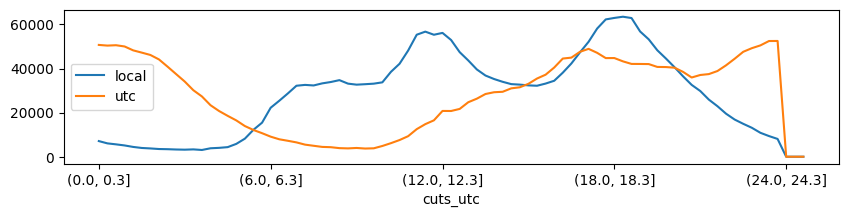

In [56]:
def get_hour_of_day(datetime_series):
    return datetime_series.dt.hour + datetime_series.dt.minute/60 + datetime_series.dt.second/3600
temp = df_bolus.sample(frac=0.5)


plt.figure(figsize=(10, 2)); ax = plt.gca()
temp['cuts_local'] = pd.cut(get_hour_of_day(df_bolus.datetime), np.arange(0,25,0.3))
temp['cuts_utc'] = pd.cut(get_hour_of_day(df_bolus.UTCDtTm), np.arange(0,25,0.3))
temp.groupby('cuts_local').Normal.sum().plot(label='local')
temp.groupby('cuts_utc').Normal.sum().plot(label='utc')
plt.legend()

### Conclusion 

* There are some duplicated temporal Boluses ~3% 
* These boluses are mostly equal but in rare cases significantly different (reason unclear)
* Extended boluses exist and should be separted, it appears that Duration is always given in milliseconds


## Basal

In [45]:
## export Basal to parquet if not already done
basal_parquet_path = os.path.join(loop_paquet_path, 'basal')

if not os.path.exists(basal_parquet_path):
    basal_columns = ['PtID', 'UTCDtTm', 'BasalType', 'Duration', 'ExpectedDuration', 'Percnt', 'Rate', 'SuprBasalType', 'SuprDuration', 'SuprRate', 'TmZnOffset']
    ddf_basal = dd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceBasal*.txt'), sep='|', 
                        parse_dates=['UTCDtTm'], date_format='%Y-%m-%d %H:%M:%S', 
                        usecols=basal_columns)
    ddf_basal.to_parquet(os.path.join(basal_parquet_path, 'basal'), partition_on='PtID')
else:
    print(f'Parquet files already exist in {basal_parquet_path}')

Parquet files already exist in /Users/jan/git/nudgebg/egvinsulin/notebooks/../data/raw/paquet/Loop study public dataset 2023-01-31/basal


In [46]:
#load parquet and a subset
ddf_basal = dd.read_parquet(basal_parquet_path, aggregate_files='PtID')

In [47]:
df_basal_sample = ddf_basal.partitions[0:10].map_partitions(lambda x: x.head(10000)).compute()

In [48]:
df_basal_sample = pd.merge(df_basal_sample, df_patient[['PtID','PtTimezoneOffset']], on='PtID', how='left')

In [49]:
## Report Columns, Nans, Duplicates, 
print('COLUMNS:')
print(df_basal_sample.columns)

print('NAN FRACTIONS')
display(100*df_basal_sample.isna().sum()/len(df_basal_sample))

COLUMNS:
Index(['UTCDtTm', 'BasalType', 'Duration', 'ExpectedDuration', 'Percnt',
       'Rate', 'SuprBasalType', 'SuprDuration', 'SuprRate', 'TmZnOffset',
       'PtID', 'PtTimezoneOffset'],
      dtype='object')
NAN FRACTIONS


UTCDtTm              0.000
BasalType            0.000
Duration             0.000
ExpectedDuration    99.997
Percnt              99.997
Rate                 0.038
SuprBasalType        7.988
SuprDuration        99.997
SuprRate             7.988
TmZnOffset          99.468
PtID                 0.000
PtTimezoneOffset     0.000
dtype: float64

  - <0.1% Basal rates are percent (TODO: check if these rows miss the rate)
 - ~0.1% duplciates, which is very little
 - 25% don't have suppressed basal type, most miss duration

The glossary defines Suppressed events aas follows:

>Percnt: Percentage of suppressed basal that should be delivered
>SuprBasalType: Suppressed basal delivery type (suppressed basal = basal event not being delivered because this one is active)
>SuprDuration: Suppressed duration
>SuprRate: Suppressed rate

From this is it not quite clear what they mean. 



### Duplicates

In [50]:
print('DUPLICATES:')
report_duplicates(ddf_basal, ['UTCDtTm', 'PtID'], ['UTCDtTm'])

DUPLICATES:


'211166 duplicates (0.44%)'

"435830 duplicates (0.90%) ['UTCDtTm', 'PtID']"

,UTCDtTm,BasalType,Duration,ExpectedDuration,Percnt,Rate,SuprBasalType,SuprDuration,SuprRate,TmZnOffset,PtID
22448,2018-10-24 18:34:07,temp,897000,NaN,NaN,0.201,<NA>,NaN,NaN,NaN,75
22449,2018-10-24 18:34:07,temp,897000,NaN,NaN,0.201,<NA>,NaN,NaN,NaN,75
303619,2018-01-08 01:37:02,temp,374000,NaN,NaN,1.925,scheduled,NaN,0.8,NaN,102
303620,2018-01-08 01:37:02,temp,374000,NaN,NaN,1.925,scheduled,NaN,0.8,NaN,102


,UTCDtTm,BasalType,Duration,ExpectedDuration,Percnt,Rate,SuprBasalType,SuprDuration,SuprRate,TmZnOffset,PtID
430055,2018-10-14 10:00:00,temp,303065,NaN,NaN,0.0,scheduled,NaN,0.35,NaN,3
430056,2018-10-14 10:00:00,temp,901,NaN,NaN,0.0,scheduled,NaN,0.35,NaN,3
183884,2018-12-25 16:05:10,temp,898497,NaN,NaN,0.0,<NA>,NaN,NaN,NaN,6
183885,2018-12-25 16:05:10,temp,273,NaN,NaN,0.0,<NA>,NaN,NaN,NaN,6


In [51]:
ddf_basal = ddf_basal.map_partitions(lambda df: df.drop_duplicates())

### Duration

The examples show that the temporal duplicated rows have different Durations. It would be intersting to understand how the duplciates differ.  

In [57]:
duplicated_rows = ddf_basal.map_partitions(lambda df: df[df.duplicated(subset=['PtID', 'UTCDtTm'], keep=False)]).compute()
#keep only groups that differ in other columns
duplicated_rows = duplicated_rows.sort_values(['PtID', 'UTCDtTm'])

In [58]:
#get a sample
sample = duplicated_rows.head(5000)
sample['PtID'] = sample.PtID.astype('str')
display(sample.groupby(['PtID', 'UTCDtTm']).apply(lambda x: x.nunique() != 1).sum(axis=0))

/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_26245/4143609793.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['PtID'] = sample.PtID.astype('str')
/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_26245/4143609793.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display(sample.groupby(['PtID', 'UTCDtTm']).apply(lambda x: x.nunique() != 1).sum(axis=0))


UTCDtTm                0
BasalType            275
Duration            1094
ExpectedDuration    1279
Percnt              2426
Rate                1713
SuprBasalType        266
SuprDuration        2426
SuprRate             838
TmZnOffset          1075
PtID                   0
dtype: int64

In [59]:
n=6; o=np.random.randint(0, len(sample)-n)
display(sample.iloc[o:o+n].dropna(axis=1, how='all'))

,UTCDtTm,BasalType,Duration,Rate,SuprBasalType,SuprRate,PtID
232784,2019-01-16 22:25:21,temp,0,0.000,scheduled,1.150,16
232785,2019-01-16 22:25:21,temp,300267,1.199,scheduled,0.920,16
232427,2019-01-17 02:01:11,temp,0,0.000,scheduled,1.000,16
232428,2019-01-17 02:01:11,temp,241968,0.744,scheduled,0.700,16
299546,2019-01-17 11:29:40,temp,0,0.000,scheduled,0.850,16
299547,2019-01-17 11:29:40,temp,23727,0.000,scheduled,0.595,16


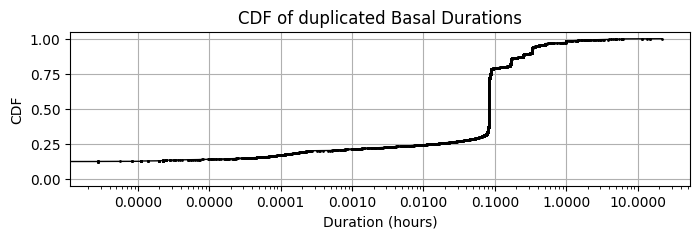

In [60]:
#plot durations for the duplicates
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
plt.figure(figsize=(8, 2)); ax = plt.gca()
cdf.plot_cdf(sample.Duration/(1000*3600),ax=ax)
plt.xscale('log'); plt.xlabel('Duration (hours)'); plt.title('CDF of duplicated Basal Durations')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))
plt.show();


Since Duration is in milliseconds (as per glossary), a lot of values are in unreasosonable ranges (seconds) and it is unclear why. We see also from the examples, that each duplicate comes with one row having a short duratino while the other row has a longer duration. What happens wif we use the max value?

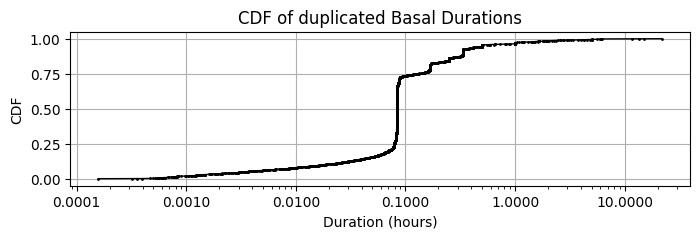

In [61]:
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(8, 2)); ax = plt.gca()
temp = sample.groupby(['PtID', 'UTCDtTm']).Duration.agg('max')
cdf.plot_cdf(temp/(1000*3600),ax=ax)
plt.xscale('log'); plt.xlabel('Duration (hours)'); plt.title('CDF of duplicated Basal Durations')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))

It appears as if one of the duplicated rows has incorrect data (very small Duration, missing type, missing rate,)
By keeping the maximum duration, we mostly remove the left tail. 
But honestly, we don't know what is going on.


### Basal Type

In [62]:
print('VALUE FRACTIONS:')
display(df_basal_sample.value_counts(subset=['BasalType'])*100/len(df_basal_sample))
display(df_basal_sample.value_counts(subset=['SuprBasalType'])*100/len(df_basal_sample))

VALUE FRACTIONS:


BasalType
temp         99.474
scheduled     0.488
suspend       0.038
Name: count, dtype: float64

SuprBasalType
scheduled        92.012
Name: count, dtype: float64

In very few cases, the suppressed basal rate is a temporary or automated basal rate. 
It is unclear where these come from, potentially set on the pump itself.

We asked JAEB about suppressed deliveries and they also didn't know what they meant and recommended reaching out to Tidepool directly. 

### Visualize Basal Rates

,UTCDtTm,BasalType,Duration,Rate,SuprBasalType,SuprRate,PtID,PtTimezoneOffset
92948,2018-01-27 01:38:31,temp,300000,0.600,scheduled,0.75,13,-1 days +19:00:00
92947,2018-01-27 01:43:31,temp,301000,0.598,scheduled,0.75,13,-1 days +19:00:00
92946,2018-01-27 01:48:32,temp,299000,0.602,scheduled,0.75,13,-1 days +19:00:00
92945,2018-01-27 01:53:31,temp,298000,0.604,scheduled,0.75,13,-1 days +19:00:00
92944,2018-01-27 01:58:29,temp,300000,0.600,scheduled,0.75,13,-1 days +19:00:00
...,...,...,...,...,...,...,...,...
91362,2018-01-27 20:43:32,temp,301000,0.598,scheduled,0.75,13,-1 days +19:00:00
91361,2018-01-27 20:48:33,temp,300000,1.200,scheduled,0.75,13,-1 days +19:00:00
91360,2018-01-27 20:53:33,temp,363000,0.992,scheduled,0.75,13,-1 days +19:00:00
91359,2018-01-27 20:59:36,temp,238000,0.756,scheduled,0.75,13,-1 days +19:00:00


Text(0.5, 1.0, 'Patient 13 on 2018-01-27')

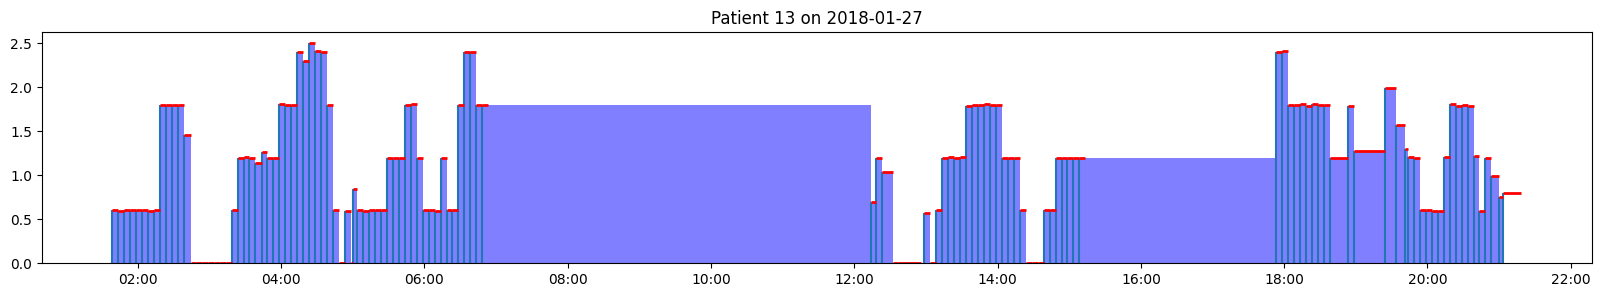

In [93]:
import matplotlib
from src import drawing

## select a patient and day that has basal rate and SuprBasalType
day, patient = df_basal_sample.dropna(subset=['Rate', 'SuprBasalType'],how='any').sample(1)[['UTCDtTm', 'PtID']].values[0]
#select data
temp = df_basal_sample.loc[(df_basal_sample.PtID == patient) & (df_basal_sample.UTCDtTm.dt.date == day.date())]
temp = temp.dropna(how='all', axis=1).sort_values('UTCDtTm')
display(temp)

f,ax = plt.subplots(figsize=(20,3)), plt.gca()
drawing.drawBasal(ax,temp.UTCDtTm,temp.Rate)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
ax.hlines(temp.Rate,temp.UTCDtTm,temp.UTCDtTm+pd.to_timedelta(temp.Duration,unit='ms'), color='red', alpha=1,linewidth=2)
#ax.hlines(temp.Rate,temp.UTCDtTm,temp.UTCDtTm+pd.to_timedelta(temp.Duration,unit='ms'), color='red', alpha=0.5,linestyles='dashed',linewidth=2)
plt.title(f'Patient {patient} on {day.date()}')

In [100]:
temp['hour_of_day']=temp.UTCDtTm.dt.hour+temp.UTCDtTm.dt.minute/60+temp.UTCDtTm.dt.second/3600
display(temp.loc[temp.hour_of_day>6.7].head(20))

,UTCDtTm,BasalType,Duration,Rate,SuprBasalType,SuprRate,PtID,PtTimezoneOffset,hour_of_day
90515,2018-01-27 06:43:31,temp,300000,1.800,scheduled,0.75,13,-1 days +19:00:00,6.725278
90514,2018-01-27 06:48:31,temp,300000,1.800,scheduled,0.75,13,-1 days +19:00:00,6.808611
99257,2018-01-27 12:14:11,temp,260000,0.692,scheduled,0.75,13,-1 days +19:00:00,12.236389
99256,2018-01-27 12:18:31,temp,301000,1.196,scheduled,0.75,13,-1 days +19:00:00,12.308611
99255,2018-01-27 12:23:32,temp,522000,1.034,scheduled,0.75,13,-1 days +19:00:00,12.392222
99254,2018-01-27 12:32:14,temp,281000,0.000,scheduled,0.75,13,-1 days +19:00:00,12.537222
99253,2018-01-27 12:36:55,temp,1123000,0.000,scheduled,0.75,13,-1 days +19:00:00,12.615278
99252,2018-01-27 12:58:31,temp,316000,0.570,scheduled,0.75,13,-1 days +19:00:00,12.975278
99251,2018-01-27 13:03:47,temp,286000,0.000,scheduled,0.75,13,-1 days +19:00:00,13.063056
99250,2018-01-27 13:08:33,temp,298000,0.604,scheduled,0.75,13,-1 days +19:00:00,13.142500


In some cases we see that the duration matches the time between two basal rates. In other cases, they don't and the durations are much shorter. The durations are only around 5-15 minutes. Unclear what is going on, let's look at examples with suppressed basal.

#### Suppressed basal rates?

,UTCDtTm,BasalType,Duration,ExpectedDuration,Percnt,Rate,SuprBasalType,SuprDuration,SuprRate,TmZnOffset,PtID,PtTimezoneOffset
60257,2019-01-21 02:00:00,scheduled,7200000,NaN,NaN,0.60,<NA>,NaN,NaN,-240.0,10,-1 days +19:00:00
60256,2019-01-21 04:00:00,scheduled,21600000,NaN,NaN,0.40,<NA>,NaN,NaN,-240.0,10,-1 days +19:00:00
60255,2019-01-21 10:00:00,scheduled,18000000,NaN,NaN,0.80,<NA>,NaN,NaN,-240.0,10,-1 days +19:00:00
60254,2019-01-21 15:00:00,scheduled,3891000,NaN,NaN,0.70,<NA>,NaN,NaN,-240.0,10,-1 days +19:00:00
60253,2019-01-21 16:04:51,temp,19000,60000.0,0.2,0.14,scheduled,60000.0,0.7,-240.0,10,-1 days +19:00:00
60252,2019-01-21 16:05:10,suspend,57000,NaN,NaN,NaN,<NA>,NaN,NaN,-240.0,10,-1 days +19:00:00
60251,2019-01-21 16:06:07,scheduled,16000,NaN,NaN,0.80,<NA>,NaN,NaN,-360.0,10,-1 days +19:00:00
60250,2019-01-21 16:06:23,temp,1734000,1740000.0,NaN,0.00,<NA>,NaN,NaN,-360.0,10,-1 days +19:00:00
60249,2019-01-21 16:35:17,scheduled,1483000,NaN,NaN,0.80,<NA>,NaN,NaN,-360.0,10,-1 days +19:00:00
60248,2019-01-21 17:00:00,scheduled,21600000,NaN,NaN,0.70,<NA>,NaN,NaN,-360.0,10,-1 days +19:00:00


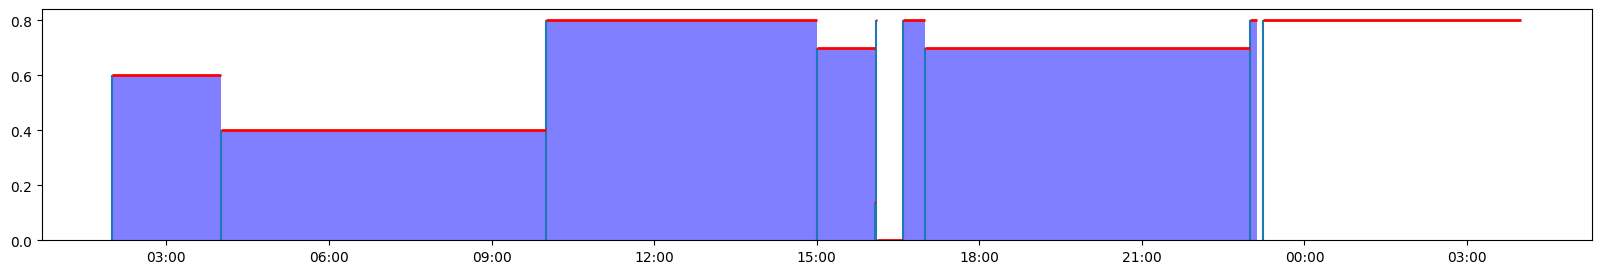

In [ ]:
## select a patient and day that has basal rate and SuprBasalType
day, patient = df_basal_sample.dropna(subset=['Rate', 'SuprBasalType','SuprDuration'],how='any').sample(1)[['UTCDtTm', 'PtID']].values[0]
temp = df_basal_sample.loc[(df_basal_sample.PtID == patient) & (df_basal_sample.UTCDtTm.dt.date == day.date())]
temp = temp.dropna(how='all', axis=1).sort_values('UTCDtTm')
display(temp['UTCDtTm', 'Rate', 'SuprBasalType','SuprDuration','Percnt','SuprRate'])

Looks like `Percnt = Rate / SuprRate`. This seems to make some sense. Loop decides on which rate to deliver (Rate) but there is a suppressed rate (where does it come from?) and calculates by which factor to change the suppressed rate in order to come to the Rate.
Intuitively, it should be the other way around: There is a target rate and loop calculates the factor by which to reduce the current active rate.
Anyways, it appears like we should be using the rate which is in line with what JAEB is saying.

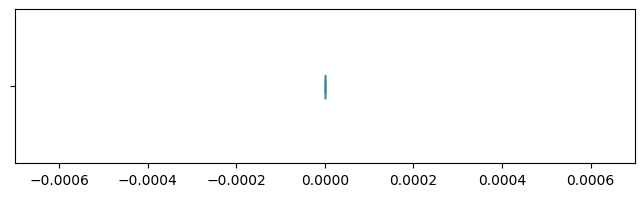

In [65]:
#show error between Rate and SuprRate*Percnt
temp = df_basal_sample.dropna(subset=['Rate','Percnt','SuprRate'], how='any')[['Rate','Percnt','SuprRate']]
#display(temp.head(10))
e = temp['Rate'] - (temp['SuprRate']*temp['Percnt'])
plt.figure(figsize=(8, 2)); ax = plt.gca()
e.plot.box(showfliers=False, vert=False, ax = ax); ax.set_xlim(-0.0007,0.0007); plt.show();

## Putting Everything together

In [66]:
from src.logger import Logger
from studies.studydataset import StudyDataset
class Loop(StudyDataset):

    def __init__(self, study_path):
        super().__init__(study_path, 'Loop')
        
        self._cgm_parquet_filename = 'loop_cgm.parquet'
        self._basal_parquet_filename = 'loop_basal.parquet'
        self._bolus_parquet_filename = 'loop_bolus.parquet'

        self.logger = Logger.get_logger('Loop')
        self.temp_dir = os.path.join(self.study_path, '..', '..', 'temp')
        self.load_subset = False
        if not os.path.exists(self.temp_dir):
            os.makedirs(self.temp_dir)
            self.logger.debug(f"Temporary directory created at {self.temp_dir}")
        
    
    def convert_csv_to_partqet(self, ddf, parquet_path, override=False):
        if os.path.exists(parquet_path) and (not override):
            self.logger.debug(f"{os.path.basename(parquet_path)} already exists. Skipping conversion.")
        else:
            self.logger.debug("{parquet_path} does not exist yet. Converting CSV to parquet.")

            # Patient data is spread across 6 large files and processing them in sequence would cause much overhead
            # therefore, export as parquet to a local directory indexed by PtID 
            # this allows us faster processing using dask later on
            ddf.to_parquet(parquet_path, partition_on='PtID')
            self.logger.debug(f"CSV files converted to parquet file {parquet_path}")

    def _load_data(self, subset: bool = False):
        self.df_patient = pd.read_csv(os.path.join(self.study_path, 'Data Tables',  'PtRoster.txt'), sep='|')
        self.load_subset = subset

        # Load the data from the CSV files and convert them to parquet files
        ddf_cgm = dd.read_csv(os.path.join(self.study_path, 'Data Tables', 'LOOPDeviceCGM*.txt'), sep='|', 
                            parse_dates=['UTCDtTm'], date_format='%Y-%m-%d %H:%M:%S', 
                            usecols=['PtID', 'UTCDtTm', 'RecordType', 'CGMVal'])
        
        
        ddf_basal = dd.read_csv(os.path.join(self.study_path, 'Data Tables', 'LOOPDeviceBasal*.txt'), sep='|', 
                                parse_dates=['UTCDtTm'], date_format='%Y-%m-%d %H:%M:%S', 
                                usecols=['PtID', 'UTCDtTm', 'BasalType', 'Duration', 'Rate'])
        self.convert_csv_to_partqet(ddf_cgm, os.path.join(self.temp_dir, self._cgm_parquet_filename))
        self.convert_csv_to_partqet(ddf_basal, os.path.join(self.temp_dir, self._basal_parquet_filename))
        
    def _extract_cgm_history(self):
        self.logger.debug("Extracting CGM history...")
        
        # Load the parquet file
        ddf = dd.read_parquet(os.path.join(self.temp_dir,self._cgm_parquet_filename), aggregate_files='PtID')
        if self.load_subset:
            ddf = ddf.partitions[:2]
        
        # Make sure divisions are set correctly
        #TODO: this can probably be removed
        #ddf = ddf.set_index('PtID', drop=False) 
        
        # keep only CGM records (removes calibrations, etc.)
        ddf = ddf.loc[ddf.RecordType == 'CGM']
        ddf.index = ddf.index.astype('int')  # Workaround to omit error when there are no rows left

        #drop duplicates
        ddf = ddf.map_partitions(lambda df: df.drop_duplicates(subset=['UTCDtTm', 'CGMVal']))

        # Convert to mg/dL
        ddf['CGMVal'] = ddf.CGMVal * 18.018

        # Convert to local datetime
        ddf = ddf.map_partitions(lambda df: df.merge(self.df_patient[['PtID', 'PtTimezoneOffset']], on='PtID', how='left'))
        ddf['UTCDtTm'] = ddf['UTCDtTm'] + dd.to_timedelta(ddf['PtTimezoneOffset'], unit='hour')

        # Reduce, Rename, Return
        ddf = ddf.drop(columns=['PtTimezoneOffset', 'RecordType'])

        # Convert Dask DataFrame to pandas DataFrame
        self.logger.debug("Converting Dask DataFrame to pandas DataFrame")
        
        #TODO: This is just for testing
        start_time = time.time()
        df_cgm = ddf.compute()
        self.logger.debug(f"compute() took: {time.time() - start_time} seconds")

        #TODO: Check if reset_index can be done before compute() without harming performance
        start_time = time.time()
        df_cgm.reset_index(inplace=True)
        df_cgm['PtID'] = df_cgm['PtID'].astype('str')
        df_cgm.rename(columns={'PtID': self.COL_NAME_PATIENT_ID, 
                               'CGMVal': self.COL_NAME_CGM, 
                               'UTCDtTm': self.COL_NAME_DATETIME}, inplace=True)
        self.logger.debug(f"The rest took: {time.time() - start_time} seconds")

        return df_cgm

    def _extract_bolus_event_history(self):
        # Load the parquet file
        df = pd.read_csv(os.path.join(self.study_path, 'Data Tables', 'LOOPDeviceBolus.txt'), sep='|', 
                                parse_dates=['UTCDtTm'], date_format='%Y-%m-%d %H:%M:%S',
                                usecols=['PtID', 'UTCDtTm', 'Normal', 'Extended', 'Duration'])
        
        #drop duplicates
        df = df.drop_duplicates(subset=['PtID', 'UTCDtTm'])
        
        # Convert to local datetime
        df = df.merge(self.df_patient[['PtID', 'PtTimezoneOffset']], on='PtID', how='left')
        df['UTCDtTm'] = df.UTCDtTm + pd.to_timedelta(df.PtTimezoneOffset, unit='hour')

        #split extended and normal boluses
        #for normal boluses the delivery duration = 0
        normal = df.drop(columns=['Extended'])
        normal['Duration'] = pd.to_timedelta(0, unit='millisecond')

        #extended boluses have a delivery duration
        extended = df.drop(columns=['Normal']).dropna(subset=['Extended']).rename(columns={"Extended": "Normal"})
        extended['Duration'] = pd.to_timedelta(extended.Duration, unit='millisecond')
        df = pd.concat([normal, extended], axis=0).sort_values('UTCDtTm')
        
        # Reduce, Rename, Return
        df = df.drop(columns=['PtTimezoneOffset'])

        df['PtID'] = df['PtID'].astype('str')
        df.rename(columns={'PtID': self.COL_NAME_PATIENT_ID,
                            'Normal': self.COL_NAME_BOLUS,
                            'Duration': self.COL_NAME_BOLUS_DELIVERY_DURATION,
                            'UTCDtTm': self.COL_NAME_DATETIME}, inplace=True)

        return df

    def _extract_basal_as_dask(self):
        # Load the parquet file
        ddf = dd.read_parquet(os.path.join(self.temp_dir, self._basal_parquet_filename), 
                              aggregate_files='PtID',
                              usecols=['PtID', 'UTCDtTm', 'Rate'])
        if self.load_subset:
            ddf = ddf.partitions[:10]
        
        # Make sure divisions are set correctly
        #ddf = ddf.set_index('PtID')
        
        #sort by datetime 
        #TODO: Check if it was not sorted
        ddf = ddf.map_partitions(lambda df: df.sort_values('UTCDtTm'))

        #drop duplicates
        ddf = ddf.map_partitions(lambda df: df.drop_duplicates(subset=['UTCDtTm']))

        # Convert to local datetime
        ddf = ddf.map_partitions(lambda df: df.merge(self.df_patient[['PtID', 'PtTimezoneOffset']], on='PtID', how='left'))
        ddf['UTCDtTm'] = ddf['UTCDtTm'] + dd.to_timedelta(ddf['PtTimezoneOffset'], unit='hour')

        # Rename, Reduce, Return
        ddf  = ddf.rename(columns={'PtID': self.COL_NAME_PATIENT_ID,
                                  'UTCDtTm': self.COL_NAME_DATETIME,
                                  'Rate': self.COL_NAME_BASAL_RATE}) 
        ddf = ddf[[self.COL_NAME_PATIENT_ID, self.COL_NAME_DATETIME, self.COL_NAME_BASAL_RATE]]
        return ddf
    
    def _extract_basal_event_history(self):
        ddf = self._extract_basal_as_dask()
        ddf = ddf.reset_index()
        ddf = ddf.astype({self.COL_NAME_PATIENT_ID: 'str'})

        # Convert Dask DataFrame to pandas DataFrame
        self.logger.debug("Converting Dask DataFrame to pandas DataFrame")
        start_time = time.time() #TODO: Remove these
        df = ddf.compute()
        self.logger.debug(f"compute() took: {time.time() - start_time} seconds")

        start_time = time.time()
        df.reset_index(inplace=True)
        
        df.rename(columns={'PtID': self.COL_NAME_PATIENT_ID, 
                           'Rate': self.COL_NAME_BASAL_RATE, 
                           'UTCDtTm': self.COL_NAME_DATETIME}, inplace=True)
        
        self.logger.debug(f"The rest took: {time.time() - start_time} seconds")

## Verifying TDDs

There re many open questions:

**Basal:**
- Why are Durations shorter than the next Basal rate
- Are these only deviations from standard basal rate?
- What are suppressed events?

**Boluses**
- Why are there temporal duplicates in boluses?
- Why do the Boluses deviate so much?
- Which basal rate should we trust when closed loop mode is disabled?
- We don’t have information about when user switches between open and closed loop mode.

One way we can validate our assumptions is by calculating TDD and comparing this to expected values. 

We do this by comparing our calculations with those provided by JAEB in the GluIndices file which privdes monthly averages for totalDailyIns, totalDailyInsBasal and totalDailyInsBolus (how these are calculated is unclear).

In [67]:
import pandas as pd
import numpy as np
from datetime import timedelta
from src.logger import Logger
logger = Logger().get_logger(__name__)
def durations_since_previous_valid_value(dates, values):
    """
    Calculate the durations between each date and the previous date with a valid value (non NaN).

    Parameters:
    dates (list): A list of dates.
    values (list): A list of values.

    Returns:
    list: A list of durations between each date and the previous valid date. NaN if there is no previous valid date.
    """
    last_valid_date = None
    durations = []
    for (date, value) in zip(dates, values):
        duration = np.nan
        if last_valid_date is not None:
            duration = date - last_valid_date
        if not np.isnan(value):
            last_valid_date = date
        durations.append(duration)
    return durations

def combine_and_forward_fill(df, colname_date, col_name_value, gap: timedelta):
    #forward fill, but only if duration between values is smaller than the threshold
    combined_df = df.copy() 
    combined_df['temp'] = df[col_name_value].ffill()
    durations = pd.Series(durations_since_previous_valid_value(combined_df[colname_date], combined_df[col_name_value])) 
    bSmallGap = durations <=  gap
    combined_df.loc[bSmallGap, col_name_value] = combined_df.temp
    return combined_df.drop(columns=['temp'])


def calculate_daily_basal_dose(df):
    """
    Calculate the Total Daily Dose (TDD) of basal insulin for each day in the given DataFrame.
    
    Args:
        df (pandas.DataFrame): The DataFrame containing the insulin data.
    
    Returns:
        pandas.DataFrame: The daily basal rates DataFrame with two columns: 'date' and 'basal'. 
        The 'date' column contains the dates of each day, and the 'basal' column contains the calculated TDDs.
    
    Required Column Names:
        - datetime: The timestamp of each basal insulin rate event.
        - basal_rate: The basal insulin rate event [U/hr].
    """ 
    
    if df.empty:
        logger.error('Empty dataframe passed to calculate daily basal dose')
        raise ValueError('Empty dataframe passed to calculate daily basal dose')

    valid_days = df.groupby(df.datetime.dt.date).datetime.count()>0
    valid_days = valid_days.reindex(pd.date_range(df.datetime.min().date(), df.datetime.max().date(), freq='D'), fill_value=False)


    #forward fill
    #add support points around midnight for forward filling
    supports = pd.date_range(df.datetime.min().date(), df.datetime.max().date() + pd.Timedelta(days=1), freq='D')
    missing_supports = supports[~supports.isin(df.datetime)]
    copy = df.copy()
    copy = pd.concat([copy, pd.DataFrame({'datetime': missing_supports})]).sort_values(by='datetime').reset_index(drop=True)
    copy['basal_rate'] = copy['basal_rate'].ffill()

    #display(copy)
    #make sure midnights are included for both days
    daydelta= pd.Timedelta(days=1)
    copy['date'] = copy.datetime.dt.date
    copy['date_before'] = copy.datetime.dt.date-daydelta
    copy['midnight'] = copy.date == copy.datetime
    copy['date'] = copy.apply(lambda row: {row['date']} if not row['midnight'] else {row['date'], row['date']-daydelta}, axis=1)
    copy = copy.drop(columns=['date_before','midnight'])
    copy = copy.explode('date')
    #this results in an additional day group before/after the first/last date which we don't want
    copy = copy.loc[~copy.date.isin([copy.date.max(),copy.date.min()])]
    #display(copy)

    #calcualte tdd
    def tdd(df):
        x = (df.datetime.diff().dt.total_seconds()/3600)[1:]
        y = df['basal_rate'][:-1]
        if len(x) == 0:
            r= np.nan
        else:
            r = np.sum(x.values * y.values)
        return r

    tdds = copy.groupby('date').apply(tdd).to_frame().rename(columns={0:'basal'})

    #exclude invalid days
    tdds.loc[valid_days.index[~valid_days]] = np.nan
    return tdds

def calculate_daily_bolus_dose(df):
    """
    Calculate the daily bolus dose for each patient.
    Parameters:
        df (pandas.DataFrame): The input DataFrame containing the following columns:
            - datetime (datetime): The date and time of the bolus dose.
            - bolus (float): The amount of bolus dose.
    Returns:
        pandas.DataFrame: A DataFrame with the daily bolus dose for each patient, grouped by patient_id and date.
    """
    return df.groupby(df.datetime.dt.date).agg({'bolus': 'sum'}).rename_axis('date')

### Load JAEB TDDs

In [68]:
#load tdds from glossary
df_gluindices = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'GluIndices.txt'), sep='|', 
                            dtype={'SubjectID': 'str'})
df_gluindices = df_gluindices[['SubjectID','Period','totalDailyInsBasal','totalDailyInsBolus','totalDailyIns']].rename(columns={'SubjectID': 'patient_id',
                                                                        'totalDailyInsBasal': 'tdd_basal',
                                                                        'totalDailyInsBolus': 'tdd_bolus',
                                                                        'totalDailyIns': 'tdd_total'})
display(df_gluindices.head(5))

,patient_id,Period,tdd_basal,tdd_bolus,tdd_total
0,4,Baseline,43.0,29.0,72.0
1,4,Month 3,33.0,40.0,73.0
2,4,Month 6,27.0,29.0,55.0
3,4,Months 1-6,31.0,35.0,66.0
4,4,Month 9,32.0,34.0,66.0


### Calculate Basal TDD

In [69]:
loop = Loop(loop_path)
loop.load_data(subset=False)
ddf_basal = loop._extract_basal_as_dask()

[19:01:07] loop_cgm.parquet already exists. Skipping conversion.
[19:01:07] loop_basal.parquet already exists. Skipping conversion.


In [70]:
def wrapper_tdd(df):
    tdds = calculate_daily_basal_dose(df).reset_index()
    return tdds.assign(patient_id=df.patient_id.iloc[0])

tdd_basal = ddf_basal.map_partitions(wrapper_tdd).compute()
copy = tdd_basal.copy()

tdd_basal['patient_id']=tdd_basal['patient_id'].astype('str')
display(tdd_basal.head())
tdd_basal.to_csv(os.path.join(out_path, 'tdd_basal.csv'), index=False)

/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_26245/3315765040.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tdds = copy.groupby('date').apply(tdd).to_frame().rename(columns={0:'basal'})
/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_26245/3315765040.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tdds = copy.groupby('date').apply(tdd).to_frame().rename(columns={0:'basal

,date,basal,patient_id
0,2018-09-08,NaN,3
1,2018-09-09,9.850362,3
2,2018-09-10,13.117737,3
3,2018-09-11,9.351565,3
4,2018-09-12,14.634642,3


In [71]:
#restore previously saved from file
tdds_basal = pd.read_csv(os.path.join(out_path, 'tdd_basal.csv'),dtype={'patient_id': 'str'})
tdds_basal['date'] = pd.to_datetime(tdds_basal['date'],format='%Y-%m-%d').dt.date;
tdds_basal = tdds_basal.rename(columns={'0': 'tdd_basal'})

### Calculate Montly aggregate to match JAEB reporting format

In [105]:
#tdd_basal_agg = tdds_basal.groupby('patient_id').apply(lambda df: df.loc[(df['date'] <= df['date'].min()+timedelta(days=6*30))]['tdd_basal'].mean())
#tdd_basal_agg = tdd_basal_agg.reset_index().rename(columns={0: 'tdd_basal'})

#calculate tdd average for month 1-6 
def calc_tdd_by_period(df,value_col):
    result = { 
        'Months 1-6': df.loc[(df['date'] <= df['date'].min()+timedelta(days=6*30))][value_col].mean(),
    }
    return pd.Series(result)
tdd_basal_agg = tdds_basal.groupby('patient_id').apply(calc_tdd_by_period,value_col='basal').reset_index().rename(columns={0: 'tdd_basal'})
tdd_basal_agg = tdd_basal_agg.melt(id_vars=['patient_id'], value_vars=['Months 1-6'], var_name='Period', value_name='tdd_basal')
display(tdd_basal_agg)

/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_26245/1300480772.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tdd_basal_agg = tdds_basal.groupby('patient_id').apply(calc_tdd_by_period,value_col='basal').reset_index().rename(columns={0: 'tdd_basal'})


,patient_id,Period,tdd_basal
0,10,Months 1-6,17.092397
1,100,Months 1-6,25.898119
2,1000,Months 1-6,7.816168
3,1001,Months 1-6,18.406381
4,1002,Months 1-6,9.408885
...,...,...,...
840,995,Months 1-6,26.442087
841,996,Months 1-6,33.759286
842,997,Months 1-6,19.351462
843,998,Months 1-6,27.547249


Text(0, 0.5, 'TDD Calculated')

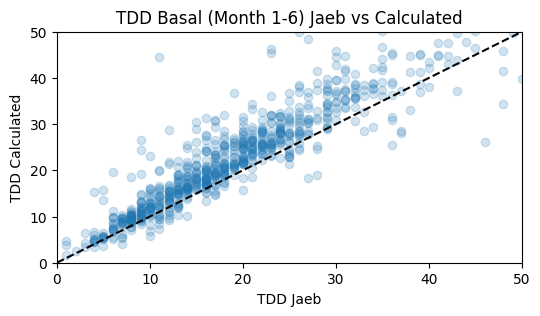

In [111]:
#merge
tdd_merged = pd.merge(left=df_gluindices.loc[df_gluindices.Period=='Months 1-6'], 
         right=tdd_basal_agg, on=['patient_id','Period'], how='inner',
         suffixes=('_jaeb','_calc'))

#draw
plt.figure(figsize=(6,3))
plt.scatter(tdd_merged.tdd_basal_jaeb, tdd_merged.tdd_basal_calc, alpha=0.2)
plt.xlim(0, 50); plt.ylim(0, 50)
plt.plot([0,50],[0,50], color='black', linestyle='--')
plt.title('TDD Basal (Month 1-6) Jaeb vs Calculated');
plt.xlabel('TDD Jaeb'); plt.ylabel('TDD Calculated')

### Calculate Bolus TDD
Next step: Combine basal with bolus tdd and do the same scatter plot
How: Calculate tdds from df_bolus, merge and scatter plot
Result: Scatter plot of bolus jaeb vs bolus calcualted

In [ ]:
### Bolus TDD
df_bolus = loop.extract_bolus_event_history()
tdd_bolus = df_bolus.groupby('patient_id').apply(calculate_daily_bolus_dose).reset_index().rename(columns={'bolus': 'tdd_bolus'})

#calculate average tdd for month 1-6
tdd_bolus_agg = tdd_bolus.groupby('patient_id').apply(calc_tdd_by_period,value_col='tdd_bolus').reset_index()
tdd_bolus_agg = tdd_bolus_agg.melt(id_vars=['patient_id'], value_vars=['Months 1-6'], var_name='Period', value_name='tdd_bolus')
tdd_bolus_agg.head()

/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_11186/4026930622.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tdd_bolus = df_bolus.groupby('patient_id').apply(tdd.calculate_daily_bolus_dose).reset_index().rename(columns={'bolus': 'tdd_bolus'})
/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_11186/4026930622.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tdd_bolus_agg = tdd_

,patient_id,Period,tdd_bolus
0,10,Months 1-6,10.513506
1,100,Months 1-6,17.634932
2,1000,Months 1-6,11.673664
3,1001,Months 1-6,29.326389
4,1002,Months 1-6,4.880110


In [ ]:
#merge into tdd dataframe
tdd_merged = pd.merge(left=tdd_merged, right=tdd_bolus_agg, 
                      on=['patient_id','Period'], how='inner',
                      suffixes=('_jaeb','_calc'))
display(tdd_merged.head())

,patient_id,Period,tdd_basal_jaeb,tdd_bolus_jaeb,tdd_total,tdd_basal_calc,tdd_bolus_calc,tdd_bolus
0,4,Months 1-6,31.0,35.0,66.0,41.591456,32.791160,32.791160
1,5,Months 1-6,31.0,27.0,58.0,41.676412,27.726201,27.726201
2,6,Months 1-6,23.0,7.0,30.0,25.152452,7.160452,7.160452
3,7,Months 1-6,22.0,16.0,37.0,32.709594,15.611842,15.611842
4,9,Months 1-6,16.0,9.0,25.0,24.808965,10.261878,10.261878


### Draw tdds side by side

Text(0, 0.5, 'Calculated')

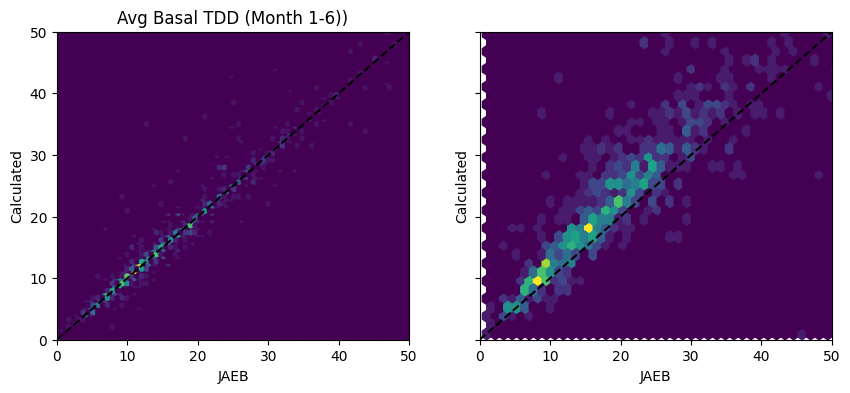

In [ ]:
#draw 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4),sharex=True, sharey=True)
ax1.hexbin(tdd_merged.tdd_bolus_jaeb, tdd_merged.tdd_bolus_calc)#alpha=0.4, color='red')
ax1.plot([0, 50], [0, 50], color='black', linestyle='--')
ax1.set_xlim(0, 50); ax1.set_ylim(0, 50)
ax1.set_title('Avg Bolus TDD (Month 1-6))')
ax1.set_xlabel('JAEB')
ax1.set_ylabel('Calculated')

ax2.hexbin(tdd_merged.tdd_basal_jaeb, tdd_merged.tdd_basal_calc,)# alpha=0.4, color='blue')
ax2.plot([0, 50], [0, 50], color='black', linestyle='--')
ax1.set_title('Avg Basal TDD (Month 1-6))')
ax2.set_xlabel('JAEB')
ax2.set_ylabel('Calculated')

Text(0.5, 1.0, 'CDF of Bolus TDD (Month 1-6)')

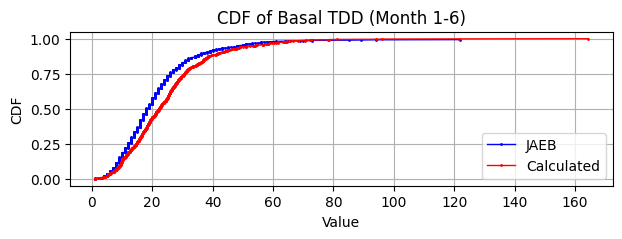

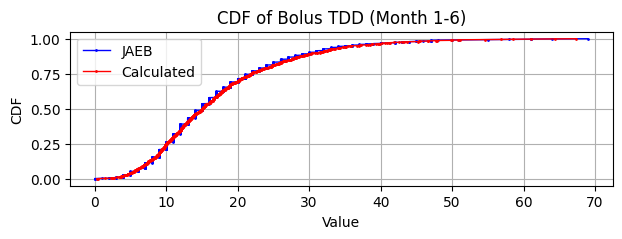

In [ ]:
from src import cdf
f=plt.figure(figsize=(7,2));ax=f.gca()
cdf.plot_cdf(tdd_merged.tdd_basal_jaeb, label='JAEB',ax=ax,color='blue')
cdf.plot_cdf(tdd_merged.tdd_basal_calc, label='Calculated',ax=ax,color='red')
plt.legend()
plt.title('CDF of Basal TDD (Month 1-6)')

f=plt.figure(figsize=(7,2));ax=f.gca()
cdf.plot_cdf(tdd_merged.tdd_bolus_jaeb, label='JAEB',ax=ax,color='blue')
cdf.plot_cdf(tdd_merged.tdd_bolus_calc, label='Calculated',ax=ax,color='red')
plt.legend()
plt.title('CDF of Bolus TDD (Month 1-6)')

### Investigate a bolus example

In [ ]:
tdd_merged.loc[abs(tdd_merged.tdd_bolus_jaeb-tdd_merged.tdd_bolus_calc)>10,['patient_id','tdd_bolus_jaeb','tdd_bolus_calc']]

,patient_id,tdd_bolus_jaeb,tdd_bolus_calc
6,11,31.0,43.703315
15,26,22.0,50.846685
26,50,13.0,35.050847
31,59,10.0,20.585061
74,121,14.0,24.770482
225,349,18.0,32.733436
235,364,25.0,42.933056
469,740,61.0,46.668310
576,919,21.0,35.884667
598,947,46.0,58.486765


In [ ]:
display(tdd_bolus.loc[tdd_bolus.patient_id=='26'].sort_values('tdd_bolus',ascending=False).head())

,patient_id,date,tdd_bolus
93470,26,2018-06-27,129.6
93451,26,2018-06-08,127.4
93428,26,2018-05-16,120.2
93364,26,2018-03-13,116.8
93380,26,2018-03-29,116.4


In [ ]:
temp = df_bolus.loc[(df_bolus.patient_id=='26') & (df_bolus.datetime.dt.date==datetime(2018, 6, 27).date())]
display(temp)

,patient_id,datetime,bolus,delivery_duration
1496625,26,2018-06-27 00:21:46,8.00,0 days 00:00:00
356508,26,2018-06-27 01:21:46,8.00,0 days 00:00:00
1496624,26,2018-06-27 03:38:34,2.00,0 days 00:00:00
356507,26,2018-06-27 04:38:34,2.00,0 days 00:00:00
1496623,26,2018-06-27 06:32:40,5.30,0 days 01:00:00
1496623,26,2018-06-27 06:32:40,5.30,0 days 00:00:00
356506,26,2018-06-27 07:32:40,5.30,0 days 00:00:00
356506,26,2018-06-27 07:32:40,5.30,0 days 01:00:00
1496622,26,2018-06-27 11:51:06,5.25,0 days 01:00:00
1496622,26,2018-06-27 11:51:06,9.55,0 days 00:00:00


In [ ]:
print(temp.bolus.sum())
print(temp.drop_duplicates(subset=['datetime']).bolus.sum())

129.60000000000002
88.1


In [ ]:
temp.loc[temp.duplicated(subset=['datetime'],keep=False)]

,patient_id,datetime,bolus,delivery_duration
1496623,26,2018-06-27 06:32:40,5.30,0 days 01:00:00
1496623,26,2018-06-27 06:32:40,5.30,0 days 00:00:00
356506,26,2018-06-27 07:32:40,5.30,0 days 00:00:00
356506,26,2018-06-27 07:32:40,5.30,0 days 01:00:00
1496622,26,2018-06-27 11:51:06,5.25,0 days 01:00:00
1496622,26,2018-06-27 11:51:06,9.55,0 days 00:00:00
356505,26,2018-06-27 12:51:06,5.25,0 days 01:00:00
356505,26,2018-06-27 12:51:06,9.55,0 days 00:00:00
1496621,26,2018-06-27 13:37:01,3.15,0 days 00:00:00
1496621,26,2018-06-27 13:37:01,5.90,0 days 01:00:00


What we see is that for this patient the same bolus exists 4 times +-1 hour and delivery duration = 0/1h 
In other cases there are two boluses at the same time.

Is this a time zone problem?
Is this double reported?

In [ ]:
temp = df_bolus.groupby(['patient_id']).apply(lambda df: df.duplicated(subset=['patient_id','datetime']).sum())
print(f'Overall, we have {temp.sum()} duplicated entries in the bolus dataset')
print(f'{(temp>0).sum()} patients are affected')
print(f'in average inly {(temp[temp>0]).mean()} duplicated entries per patient')

Overall, we have 10470 duplicated entries in the bolus dataset
160 patients are affected
in average inly 65.4375 duplicated entries per patient


/var/folders/l7/c9dz13bs7xj6lh3fncbxgwjm0000gp/T/ipykernel_11186/139527269.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp = df_bolus.groupby(['patient_id']).apply(lambda df: df.duplicated(subset=['patient_id','datetime']).sum())


### Investigate Basal TDDs
We know that some days there is no basal data or only for limited times. The question is how to fill the gaps. How did JAEB do it?
Are the basals maybe only deviations from standard basal? 

#restore previously saved from file
tdds_basal = pd.read_csv(os.path.join(out_path, 'tdd_basal.csv'),dtype={'patient_id': 'str'})
tdds_basal['date'] = pd.to_datetime(tdds_basal['date'],format='%Y-%m-%d').dt.date;
tdds_basal = tdds_basal.rename(columns={'0': 'tdd_basal'})

In [ ]:
#patient 3 has only 10 hours of basal data on day 2019-05-17
df_patient = ddf_basal.partitions[0].compute()
temp = df_patient.loc[df_patient.datetime.dt.date == datetime(2019,5,17).date()]
display(temp)
print(f'On day 2019-05-17, patient 3 basal rates only cover {temp.datetime.max()-temp.datetime.min()}')

,patient_id,datetime,basal_rate
49438,3,2019-05-17 00:01:20,0.000
49439,3,2019-05-17 00:01:25,0.000
49440,3,2019-05-17 00:06:21,0.000
49441,3,2019-05-17 00:06:24,0.000
49442,3,2019-05-17 00:11:20,0.000
...,...,...,...
49551,3,2019-05-17 09:41:20,0.000
49552,3,2019-05-17 09:41:25,1.501
49553,3,2019-05-17 10:00:00,1.501
49554,3,2019-05-17 10:01:25,0.000


On day 2019-05-17, patient 3 basal rates only cover 0 days 10:00:09


Let's look on all days for all patients

Text(0.5, 0, 'Hours')

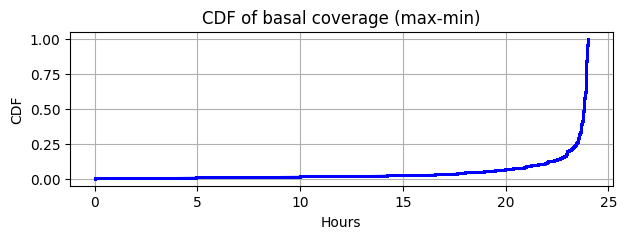

In [ ]:
basal_coverages = ddf_basal.map_partitions(lambda df: df.groupby(df.datetime.dt.date).datetime.agg(lambda x: x.max()-x.min()))
basal_coverages = basal_coverages.compute()

plt.figure(figsize=(7,2)); ax=plt.gca()
cdf.plot_cdf(basal_coverages.dt.total_seconds()/3600, label='Basal coverage', color='blue',ax=ax)
plt.title('CDF of basal coverage (max-min)')
plt.xlabel('Hours')

What we see here is that basal rates are not reported start to end. Now this might be because standard basal rates didn't change but it could also be because of missing data. **We need to clarify if** 
 - do basal rates include standard basal rates or only deviations from it?
 - what is the basal rate duration?
  